In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os

import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import neuromodels as nm
import numpy as np
import pandas as pd
import pylfi
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import mean_squared_error

[INFO] [2021.10.17 14:4:12 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2021.10.17 14:4:12 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.20.2
 Built: Oct  8 2021 07:17:41

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
size = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": size,
    "font.size": size,
    "legend.fontsize": size,
    "xtick.labelsize": size-1,
    "ytick.labelsize": size-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
plt.rc('text', usetex=True)

# Set path to save the figures
FIGURE_PATH = "./../latex/figures" 

def fig_path(fig_id):
    """
    Input name of figure to load or save with extension as dtype str
    """
    return os.path.join(FIGURE_PATH + "/", fig_id)

# Set figure size
pt = 410 #360

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

fs = set_size(pt, fraction=1)
print(fs)

(5.673170056731701, 3.5062119190183605)


In [3]:
def sem(a, axis=0):
    """Standard error of the mean (SEM)"""
    return np.std(a) / np.sqrt(a.shape[axis])

def rmse(y_true, y_pred):
    """Root mean square error (RMSE)"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmspe(y_true, y_pred):
    """Root mean square percentage error (RMSPE)"""
    rmspe = (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))) * 100
    return rmspe

### Epsilon estimation vs number of simulations 

To avoid confusion, call the following hyperparameters for tuning parameters

Quantile-based rejection: difficult to know the magnitude of the distances we could expect, as these depend on the magnitude and units of the summary statistics. Quantile-based rejection offers an automatic approach for determining the threshold value $\epsilon$.

**Estimated $\epsilon$ from prior predictive distribution** 

Estimates the mean from 10 $\epsilon$ estimations per `n_sim` value. Also estimates the standard error of the mean (SEM).

Used 0.5-quantile (median)

The quantile-based rejection algorithm estimates $\epsilon$ by running `n_sims` simulations and calculating $\epsilon$ as the provided $p$-quantile of the distances. The following figure shows the effect of the number of simulation, effectively the number of samples from the prior predictive distribution, has on the estimation of $\epsilon$. This will inform us on how many simulations we should run in the pilot study (and the effect of the prior on the estimation).

In [74]:
#fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)

# normal prior
df = pd.read_csv('data/pilot_normal.csv')
df 

,average_AP_overshoot,spike_rate,average_AP_width,average_AHP_depth,latency_to_first_spike,accommodation_index,epsilon,n_sims
0,1.956889,0.013260,0.316323,1.625726,0.053535,0.001756,1.543101,250.0
1,2.040226,0.012825,0.304714,1.092139,0.051490,0.000924,1.637147,500.0
2,1.860965,0.011833,0.280870,1.051684,0.052273,0.001382,1.535654,750.0
3,1.945049,0.012185,0.292341,1.465304,0.054815,0.002555,1.572969,1000.0
4,1.946674,0.012572,0.299770,1.337935,0.053395,0.001775,1.627874,1250.0
5,2.125556,0.013932,0.328699,1.008441,0.052826,0.000967,1.608560,1500.0


### Normal

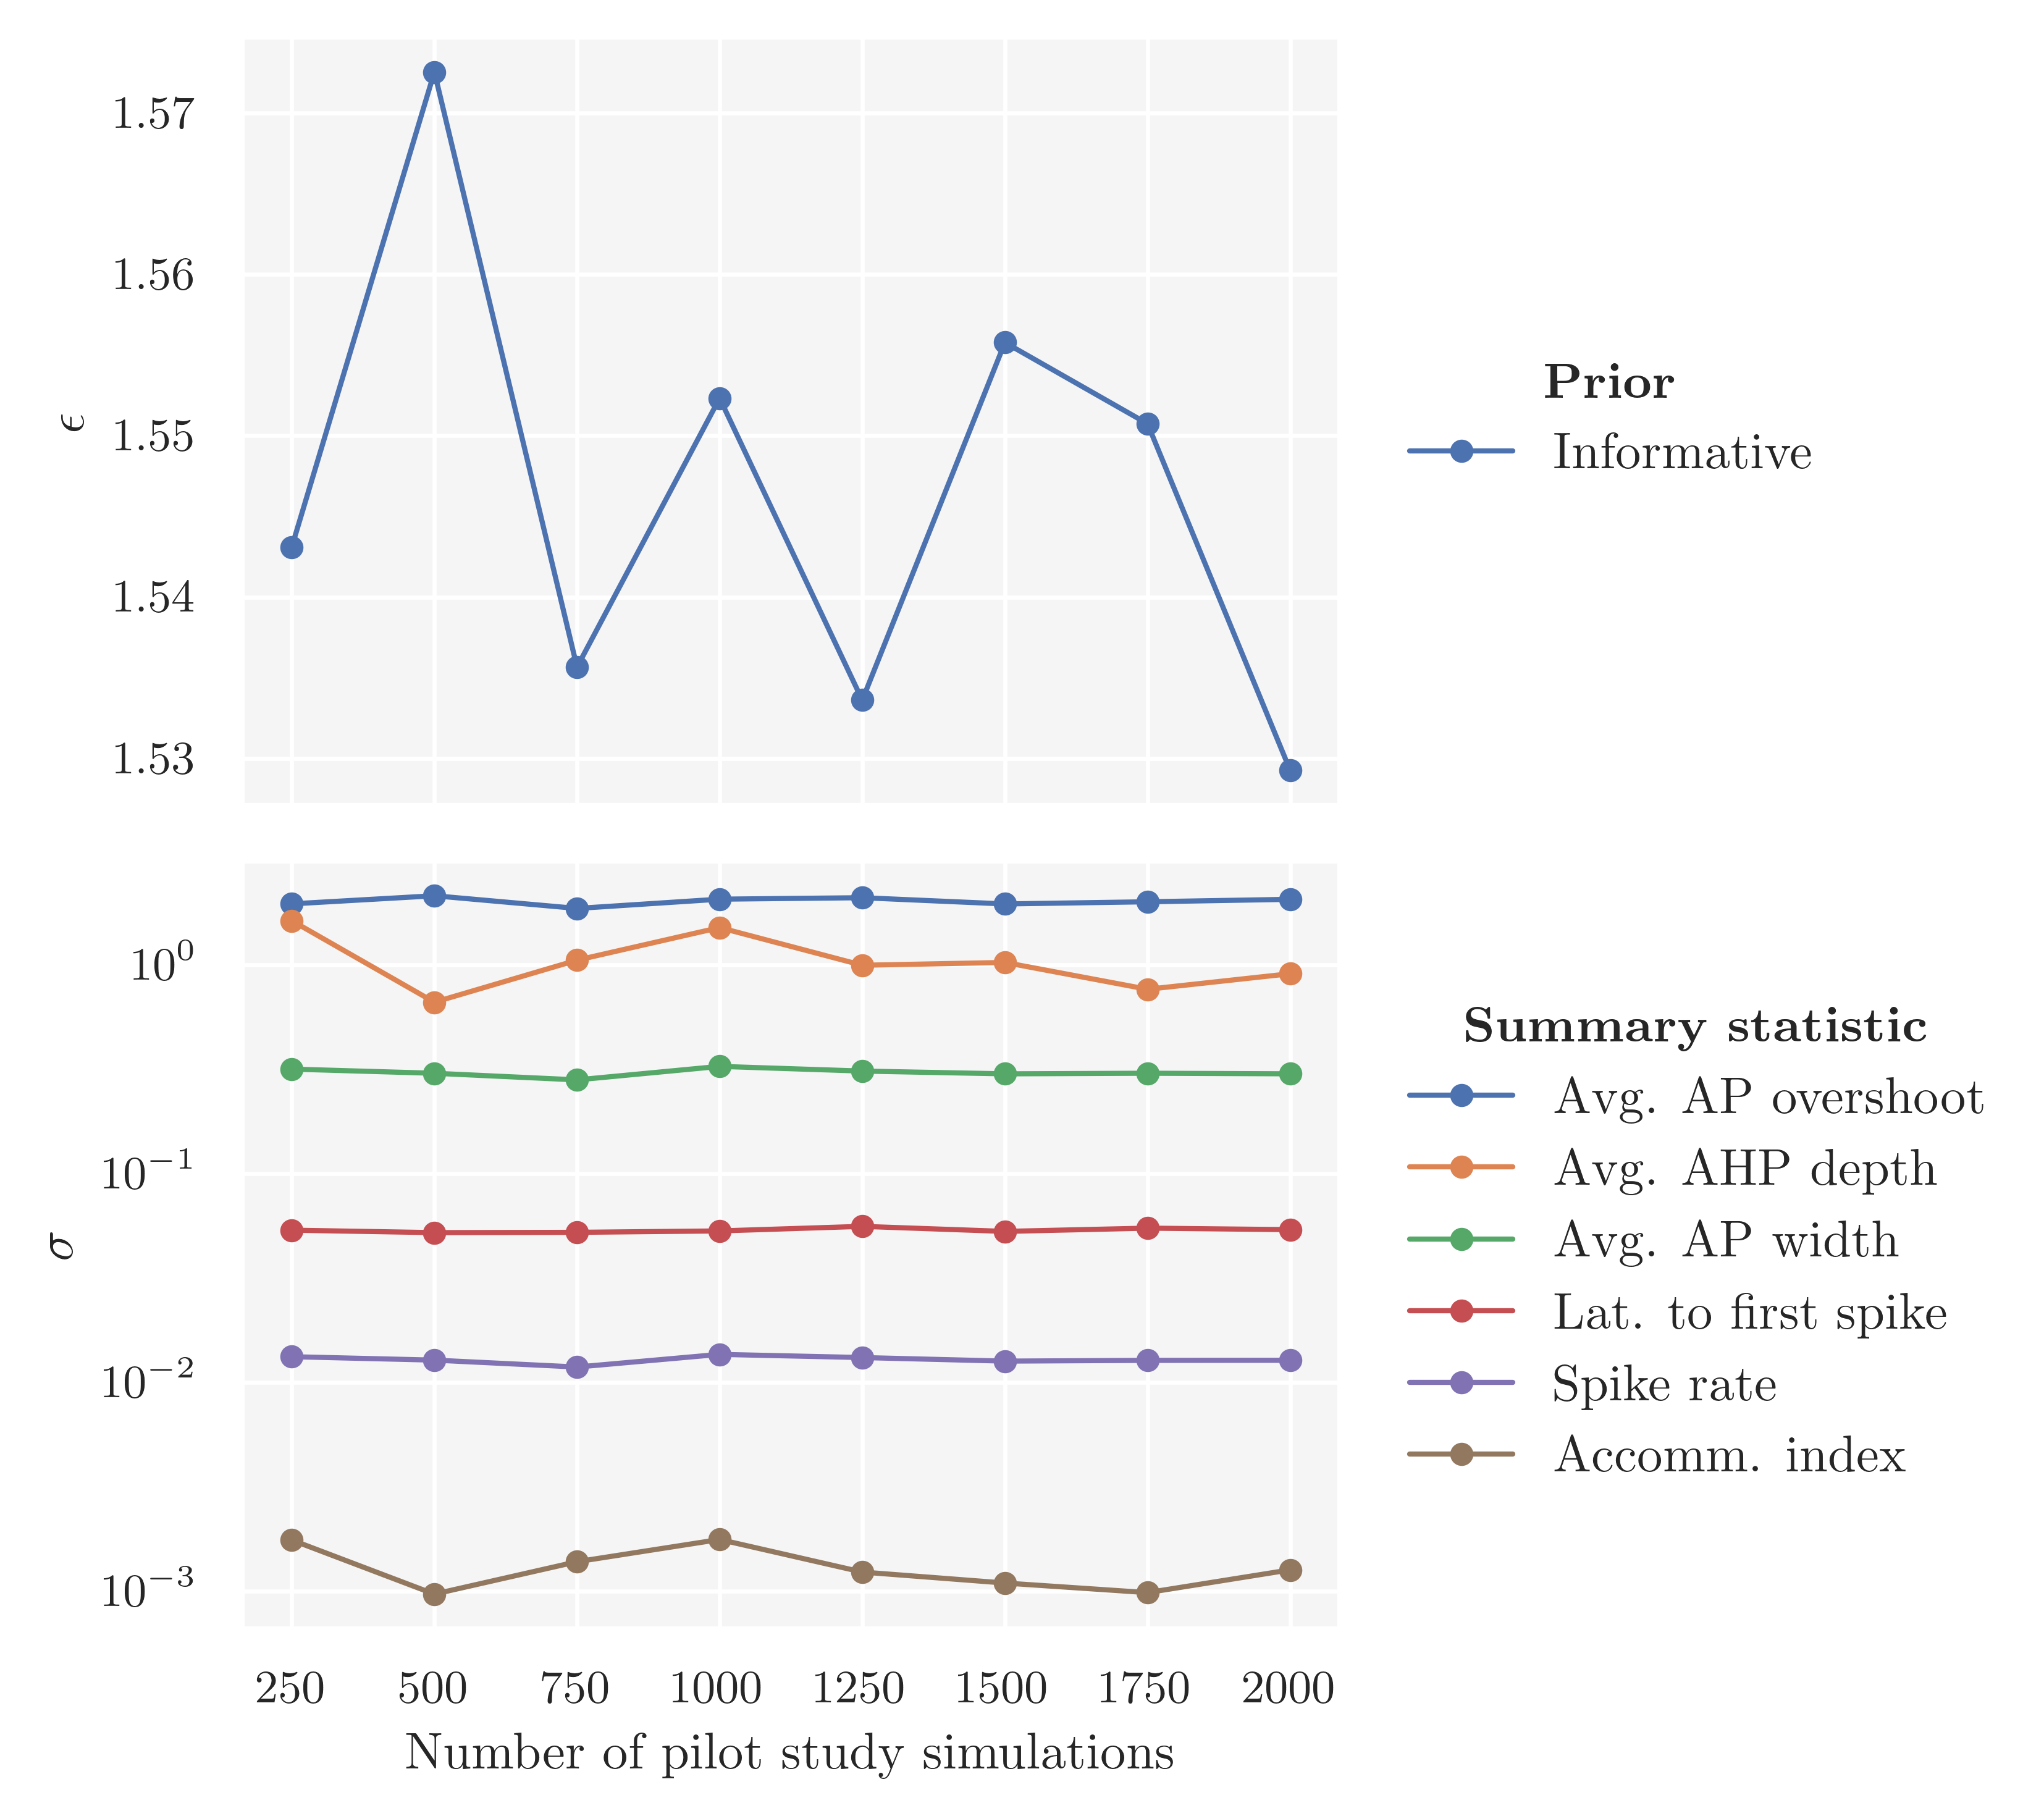

In [92]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(fs[0], 5), tight_layout=True, dpi=300, sharex=True)

df = pd.read_csv('data/pilot_normal.csv')

AP_ot_scale_n = df["average_AP_overshoot"].to_numpy()
srate_scale_n = df["spike_rate"].to_numpy()
AP_w_scale_n = df["average_AP_width"].to_numpy()
AHP_d_scale_n = df["average_AHP_depth"].to_numpy()
ltfs_scale_n = df["latency_to_first_spike"].to_numpy()
ai_scale_n = df["accommodation_index"].to_numpy()

epsilon_n = df["epsilon"].to_numpy()

n_sims = df["n_sims"].to_numpy()

ax = axes[1]

ax.plot(n_sims, AP_ot_scale_n, '-o', markersize=3.5, lw=1.0, label="Avg. AP overshoot")
ax.plot(n_sims, AHP_d_scale_n, '-o', markersize=3.5, lw=1.0, label="Avg. AHP depth")
ax.plot(n_sims, AP_w_scale_n, '-o', markersize=3.5, lw=1.0, label="Avg. AP width")
ax.plot(n_sims, ltfs_scale_n, '-o', markersize=3.5, lw=1.0, label="Lat. to first spike")
ax.plot(n_sims, srate_scale_n, '-o', markersize=3.5, lw=1.0, label="Spike rate")
ax.plot(n_sims, ai_scale_n, '-o', markersize=3.5, lw=1.0, label="Accomm. index")

ax.set(xticks=n_sims,
       xlabel="Number of pilot study simulations",
       yscale="log",
       ylabel=r'$\sigma$'
      )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          labels,
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          ncol=1,
          title=r"\textbf{Summary statistic}",
          frameon=False
         )

ax2 = axes[0]

ax2.plot(n_sims, epsilon_n, '-o', markersize=3.5, lw=1.0, label="Informative")

ax2.set(
        ylabel=r'$\epsilon$'
       )

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles,
           labels,
           loc='center left',
           bbox_to_anchor=(1.04, 0.5),
           fancybox=True,
           borderaxespad=0.1,
           ncol=1,
           title=r"\textbf{Prior}",
           frameon=False
          )

plt.show()


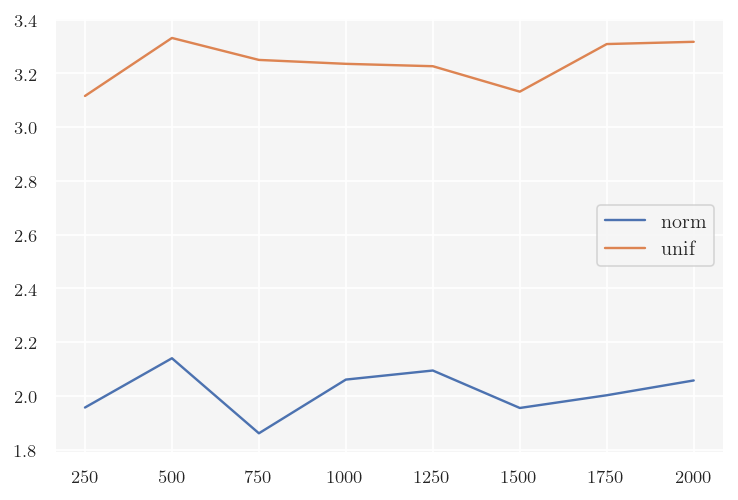

In [93]:
plt.plot(n_sims, AP_ot_scale_n, label='norm')
plt.plot(n_sims, AP_ot_scale_u, label='unif')
plt.legend()
plt.show()

### Uniform

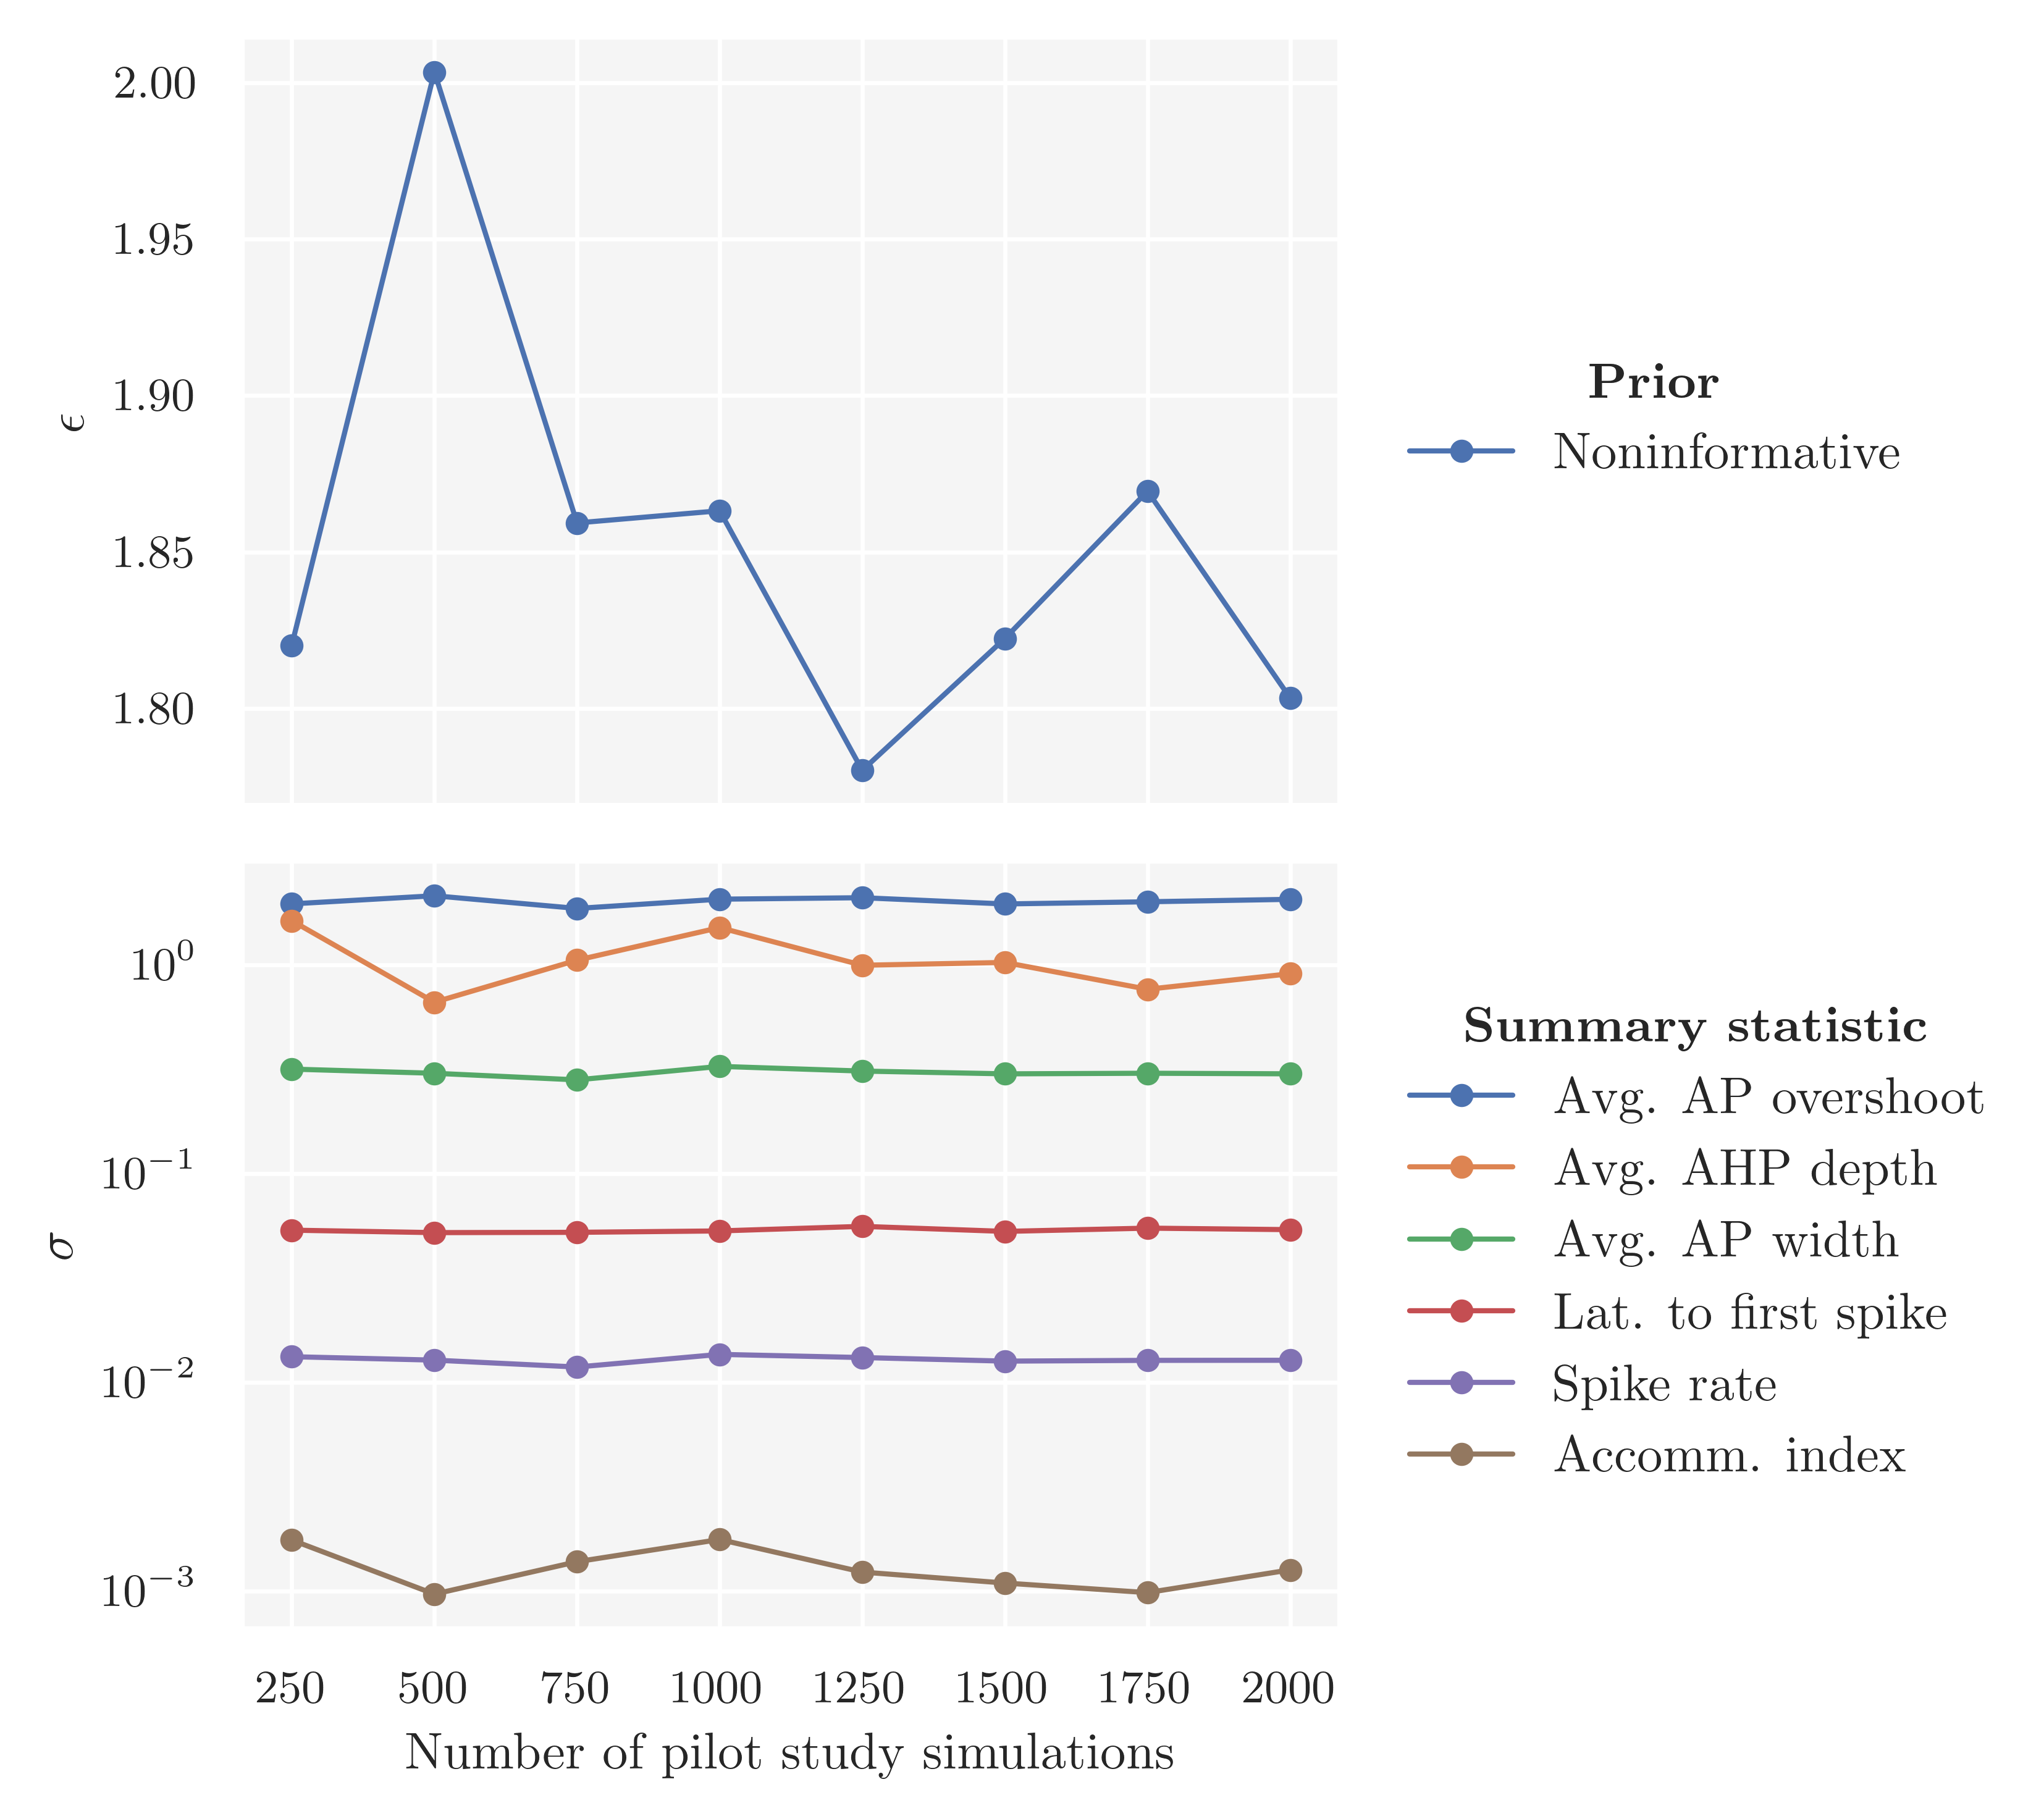

In [91]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(fs[0], 5), tight_layout=True, dpi=300, sharex=True)

df = pd.read_csv('data/pilot_uniform.csv')

AP_ot_scale_u = df["average_AP_overshoot"].to_numpy()
srate_scale_u = df["spike_rate"].to_numpy()
AP_w_scale_u = df["average_AP_width"].to_numpy()
AHP_d_scale_u = df["average_AHP_depth"].to_numpy()
ltfs_scale_u = df["latency_to_first_spike"].to_numpy()
ai_scale_u = df["accommodation_index"].to_numpy()

epsilon_u = df["epsilon"].to_numpy()

n_sims = df["n_sims"].to_numpy()

ax = axes[1]

ax.plot(n_sims, AP_ot_scale_n, '-o', markersize=3.5, lw=1.0, label="Avg. AP overshoot")
ax.plot(n_sims, AHP_d_scale_n, '-o', markersize=3.5, lw=1.0, label="Avg. AHP depth")
ax.plot(n_sims, AP_w_scale_n, '-o', markersize=3.5, lw=1.0, label="Avg. AP width")
ax.plot(n_sims, ltfs_scale_n, '-o', markersize=3.5, lw=1.0, label="Lat. to first spike")
ax.plot(n_sims, srate_scale_n, '-o', markersize=3.5, lw=1.0, label="Spike rate")
ax.plot(n_sims, ai_scale_n, '-o', markersize=3.5, lw=1.0, label="Accomm. index")

ax.set(xticks=n_sims,
       xlabel="Number of pilot study simulations",
       yscale="log",
       ylabel=r'$\sigma$'
      )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          labels,
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          ncol=1,
          title=r"\textbf{Summary statistic}",
          frameon=False
         )

ax2 = axes[0]

ax2.plot(n_sims, epsilon_u, '-o', markersize=3.5, lw=1.0, label="Noninformative")

ax2.set(
        ylabel=r'$\epsilon$'
       )

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles,
           labels,
           loc='center left',
           bbox_to_anchor=(1.04, 0.5),
           fancybox=True,
           borderaxespad=0.1,
           ncol=1,
           title=r"\textbf{Prior}",
           frameon=False
          )

plt.show()

### OLD

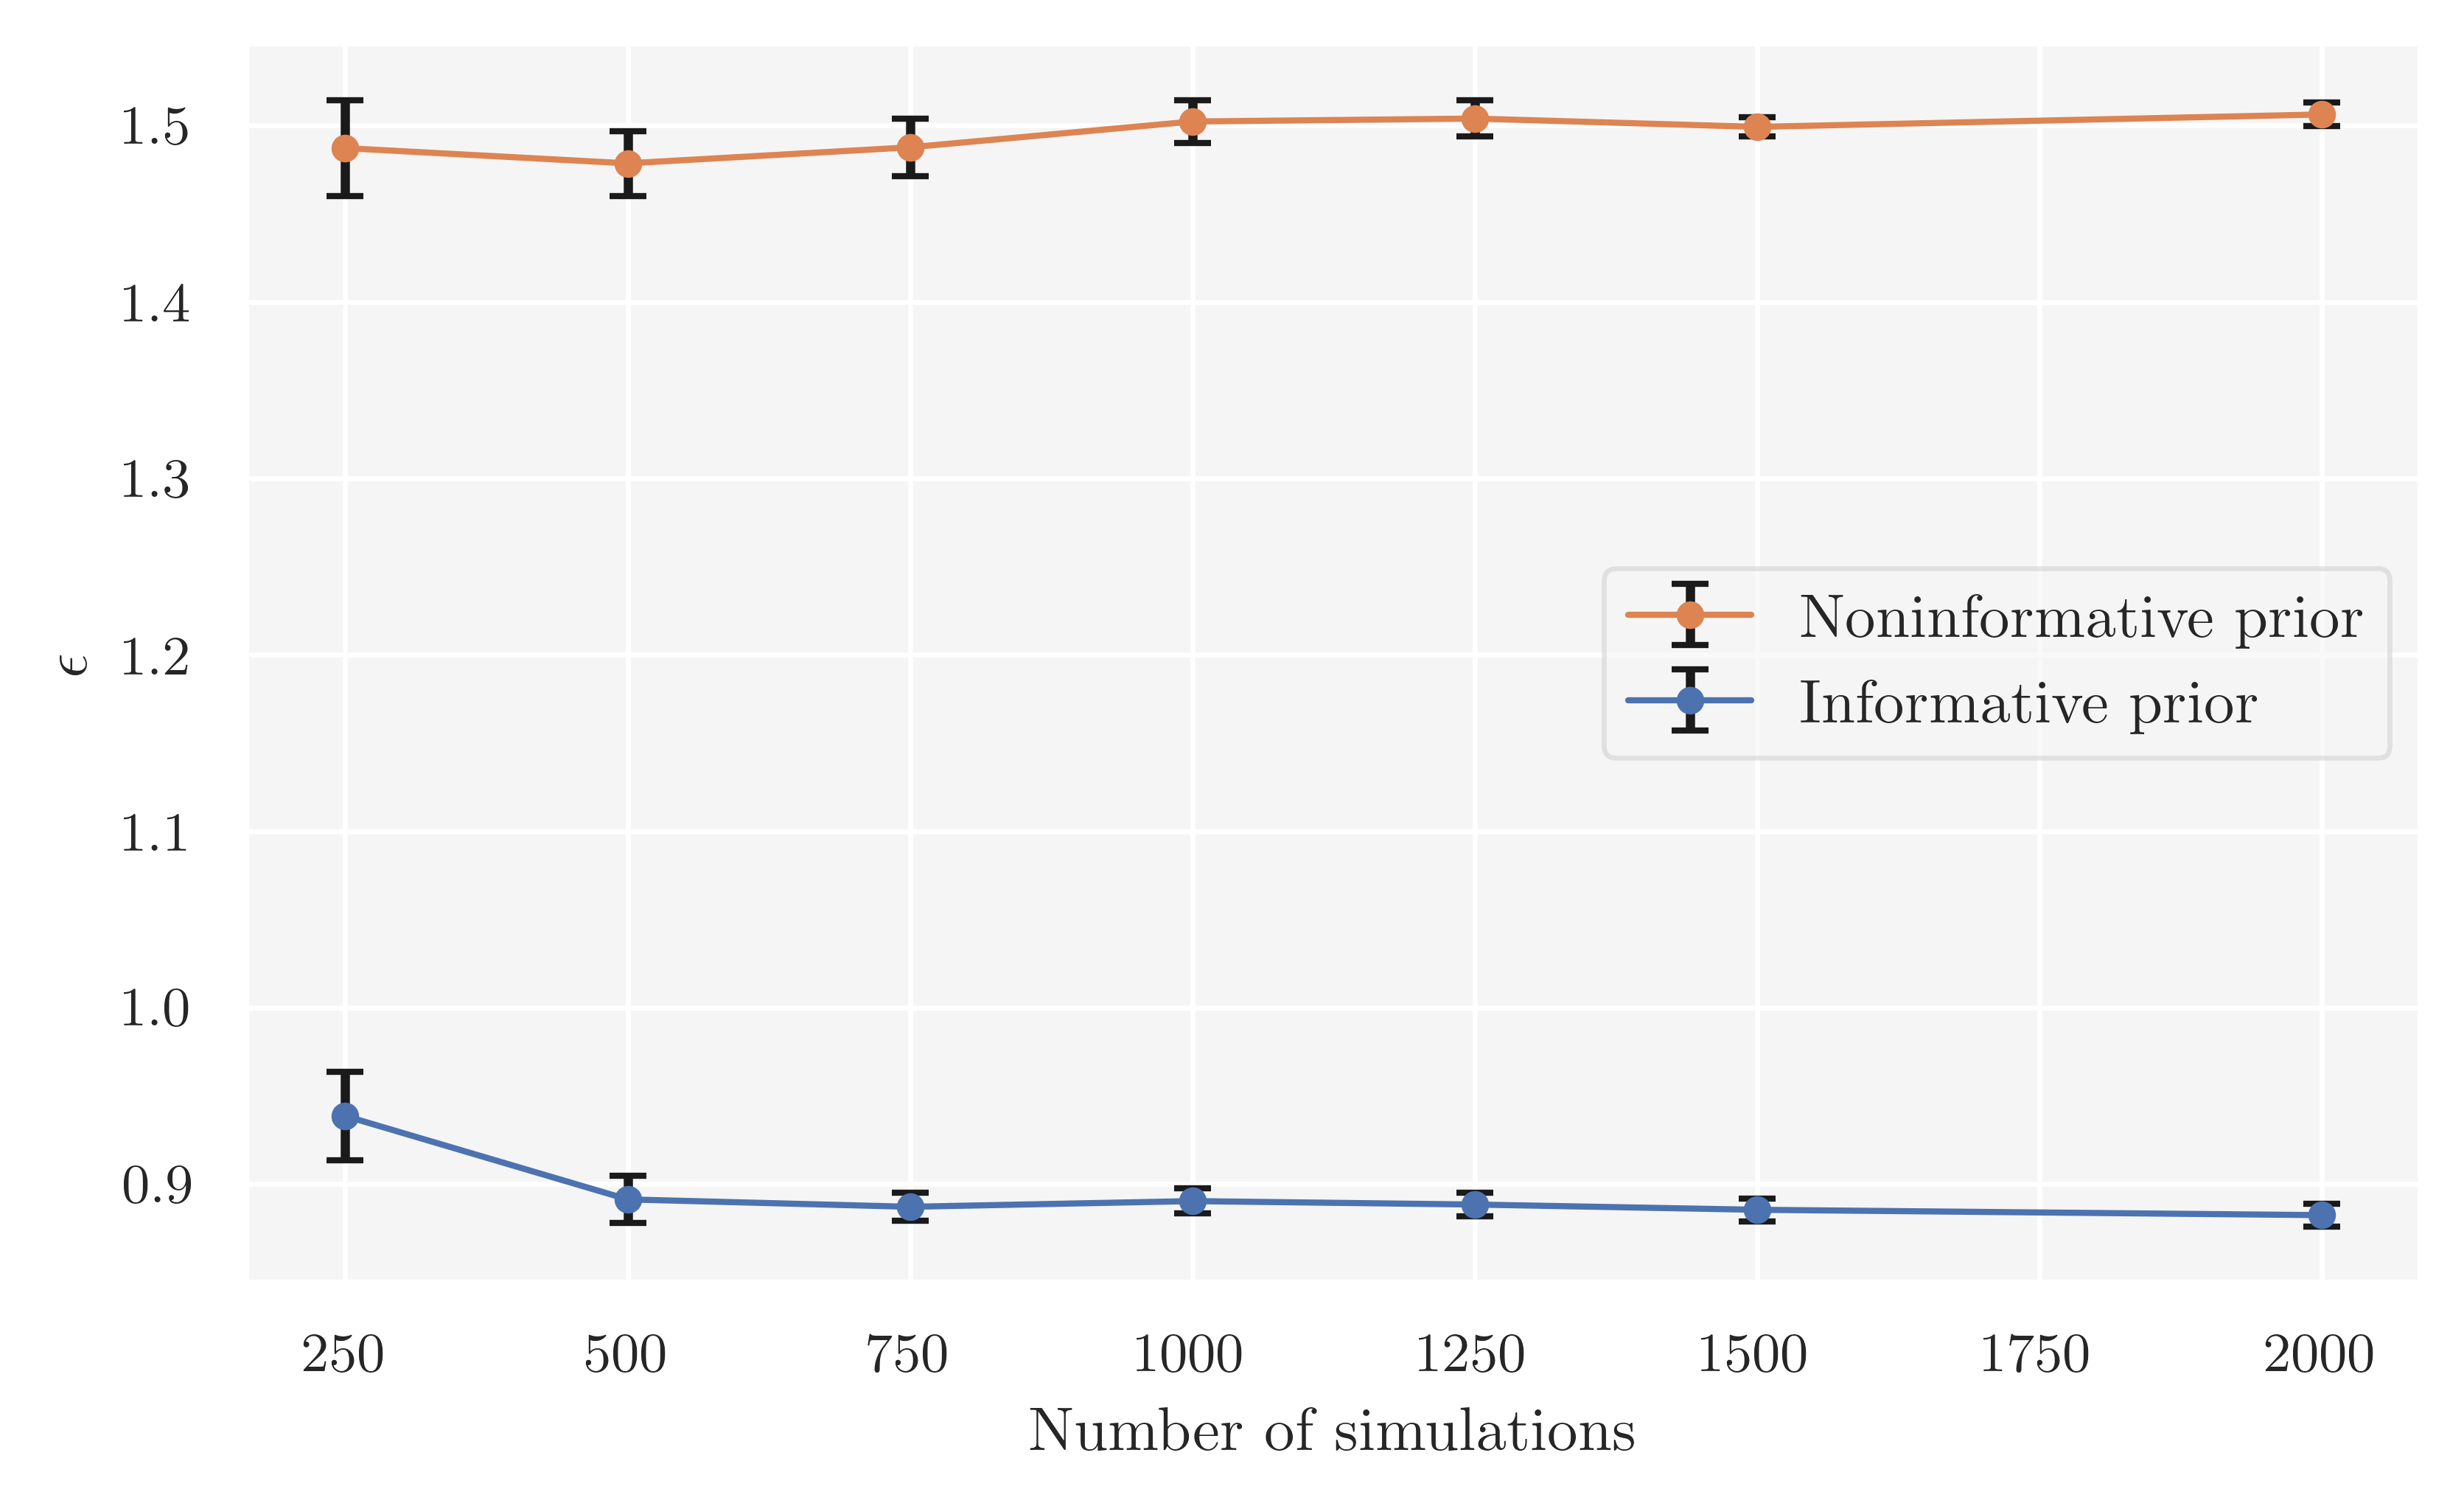

In [39]:
fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)

# normal prior
df_norm = pd.read_csv('data/pilot_eps_nsim_normal.csv')
x_norm = df_norm['n_sims'].unique()
mean_norm = df_norm.groupby('n_sims').mean().to_numpy().ravel()
sd_norm = df_norm.groupby('n_sims').sem().to_numpy().ravel() 

# uniform prior
df_unif = pd.read_csv('data/pilot_eps_nsim_uniform.csv')
x_unif = df_unif['n_sims'].unique()
mean_unif = df_unif.groupby('n_sims').mean().to_numpy().ravel()
sd_unif = df_unif.groupby('n_sims').sem().to_numpy().ravel()

ax.errorbar(x_unif, 
            mean_unif, 
            yerr=sd_unif, 
            fmt='-o', 
            color='C1',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
            label='Noninformative prior'
           )

ax.errorbar(x_norm, 
            mean_norm, 
            yerr=sd_norm, 
            fmt='-o', 
            color='C0',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
            label='Informative prior'
           ) 

ax.set(xlabel='Number of simulations',
       ylabel=r'$\epsilon$')
ax.legend(loc='center right', frameon=True, framealpha=0.5)

fig.savefig(fig_path('pilot_eps_nsims.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

With an informative prior, tradeoff between estimation accuracy and computation speed: figure indicates that 1000-1500 simulations are sufficient

With uninformative prior: 1500 - 2000. Not surprising; we sample from the prior predictive distribution and a prior with less certainty is bound to give more spread in its estimate.

Higher $\epsilon$ with uniform prior than with normal centered at ground truth values expected: the distances generated from uniform will have more variability and the parameter samples are less likely to be in the direct vicinity of the ground truth values => observed and simulated summary statistics will generally be further apart.

The colored circle markers indicate the estimated mean and the black vertical lines the estimated standard error of the mean (SEM). 

### RMSE vs quantile

RMSE averaged over 10 posteriors for each quantile value.

1000 posterior samples in each posterior

In [9]:
gbarK0 = 36.    # ground truth
gbarNa0 = 120.  # ground truth
gbarK_true = np.ones(1000) * gbarK0
gbarNa_true = np.ones(1000) * gbarNa0

path = 'data/'

# iterators
quantile_lst = [0.1, 0.3, 0.5, 0.7, 0.9]
trials = 10
N = len(quantile_lst)

# original posterior samples
gbarK_org_rmspe_mean_norm = np.zeros(N)
gbarK_org_rmspe_sem_norm = np.zeros(N)
gbarNa_org_rmspe_mean_norm = np.zeros(N)
gbarNa_org_rmspe_sem_norm = np.zeros(N)

gbarK_org_rmspe_mean_unif = np.zeros(N)
gbarK_org_rmspe_sem_unif = np.zeros(N)
gbarNa_org_rmspe_mean_unif = np.zeros(N)
gbarNa_org_rmspe_sem_unif = np.zeros(N)

# regression adjusted posterior samples
gbarK_reg_rmspe_mean_norm = np.zeros(N)
gbarK_reg_rmspe_sem_norm = np.zeros(N)
gbarNa_reg_rmspe_mean_norm = np.zeros(N)
gbarNa_reg_rmspe_sem_norm = np.zeros(N) 

gbarK_reg_rmspe_mean_unif = np.zeros(N)
gbarK_reg_rmspe_sem_unif = np.zeros(N)
gbarNa_reg_rmspe_mean_unif = np.zeros(N)
gbarNa_reg_rmspe_sem_unif = np.zeros(N)

for i, quantile in enumerate(quantile_lst):
    quantile_str = str(quantile).replace('.', '_')
    
    # original posterior samples
    trial_gbarK_rmspe_org_norm = np.zeros(trials)
    trial_gbarNa_rmspe_org_norm = np.zeros(trials)
    
    trial_gbarK_rmspe_org_unif = np.zeros(trials)
    trial_gbarNa_rmspe_org_unif = np.zeros(trials)
    
    # regression adjusted posterior samples
    trial_gbarK_rmspe_reg_norm = np.zeros(trials)
    trial_gbarNa_rmspe_reg_norm = np.zeros(trials)
    
    trial_gbarK_rmspe_reg_unif = np.zeros(trials)
    trial_gbarNa_rmspe_reg_unif = np.zeros(trials)
    
    for trial in range(trials):
        # Original posterior samples
        
        # normal prior
        filename = f'hh_rej_normal_org_quantile_{quantile_str}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        
        trial_gbarK_rmspe_org_norm[trial] = rmspe(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmspe_org_norm[trial] = rmspe(gbarNa_true, df["gbarNa"].to_numpy()) 
        
        # uniform prior
        filename = f'hh_rej_uniform_org_quantile_{quantile_str}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        
        trial_gbarK_rmspe_org_unif[trial] = rmspe(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmspe_org_unif[trial] = rmspe(gbarNa_true, df["gbarNa"].to_numpy()) 
        
        # Regression adjusted posterior samples
        
        # normal prior
        filename = f'hh_rej_normal_reg_quantile_{quantile_str}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        trial_gbarK_rmspe_reg_norm[trial] = rmspe(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmspe_reg_norm[trial] = rmspe(gbarNa_true, df["gbarNa"].to_numpy()) 
        
        # uniform prior
        filename = f'hh_rej_uniform_reg_quantile_{quantile_str}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        trial_gbarK_rmspe_reg_unif[trial] = rmspe(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmspe_reg_unif[trial] = rmspe(gbarNa_true, df["gbarNa"].to_numpy()) 
        
    # Mean and SEM of RMSPE samples
    
    # Original posterior
    
    # normal prior
    gbarK_org_rmspe_mean_norm[i] = np.mean(trial_gbarK_rmspe_org_norm)
    gbarK_org_rmspe_sem_norm[i] = sem(trial_gbarK_rmspe_org_norm) 
    gbarNa_org_rmspe_mean_norm[i] = np.mean(trial_gbarNa_rmspe_org_norm)
    gbarNa_org_rmspe_sem_norm[i] = sem(trial_gbarNa_rmspe_org_norm) 
    
    # uniform prior
    gbarK_org_rmspe_mean_unif[i] = np.mean(trial_gbarK_rmspe_org_unif)
    gbarK_org_rmspe_sem_unif[i] = sem(trial_gbarK_rmspe_org_unif) 
    gbarNa_org_rmspe_mean_unif[i] = np.mean(trial_gbarNa_rmspe_org_unif)
    gbarNa_org_rmspe_sem_unif[i] = sem(trial_gbarNa_rmspe_org_unif) 
    
    # Adjusted posterior
    # normal prior
    gbarK_reg_rmspe_mean_norm[i] = np.mean(trial_gbarK_rmspe_reg_norm)
    gbarK_reg_rmspe_sem_norm[i] = sem(trial_gbarK_rmspe_reg_norm) 
    gbarNa_reg_rmspe_mean_norm[i] = np.mean(trial_gbarNa_rmspe_reg_norm)
    gbarNa_reg_rmspe_sem_norm[i] = sem(trial_gbarNa_rmspe_reg_norm) 
    
    # uniform prior
    gbarK_reg_rmspe_mean_unif[i] = np.mean(trial_gbarK_rmspe_reg_unif)
    gbarK_reg_rmspe_sem_unif[i] = sem(trial_gbarK_rmspe_reg_unif) 
    gbarNa_reg_rmspe_mean_unif[i] = np.mean(trial_gbarNa_rmspe_reg_unif)
    gbarNa_reg_rmspe_sem_unif[i] = sem(trial_gbarNa_rmspe_reg_unif) 

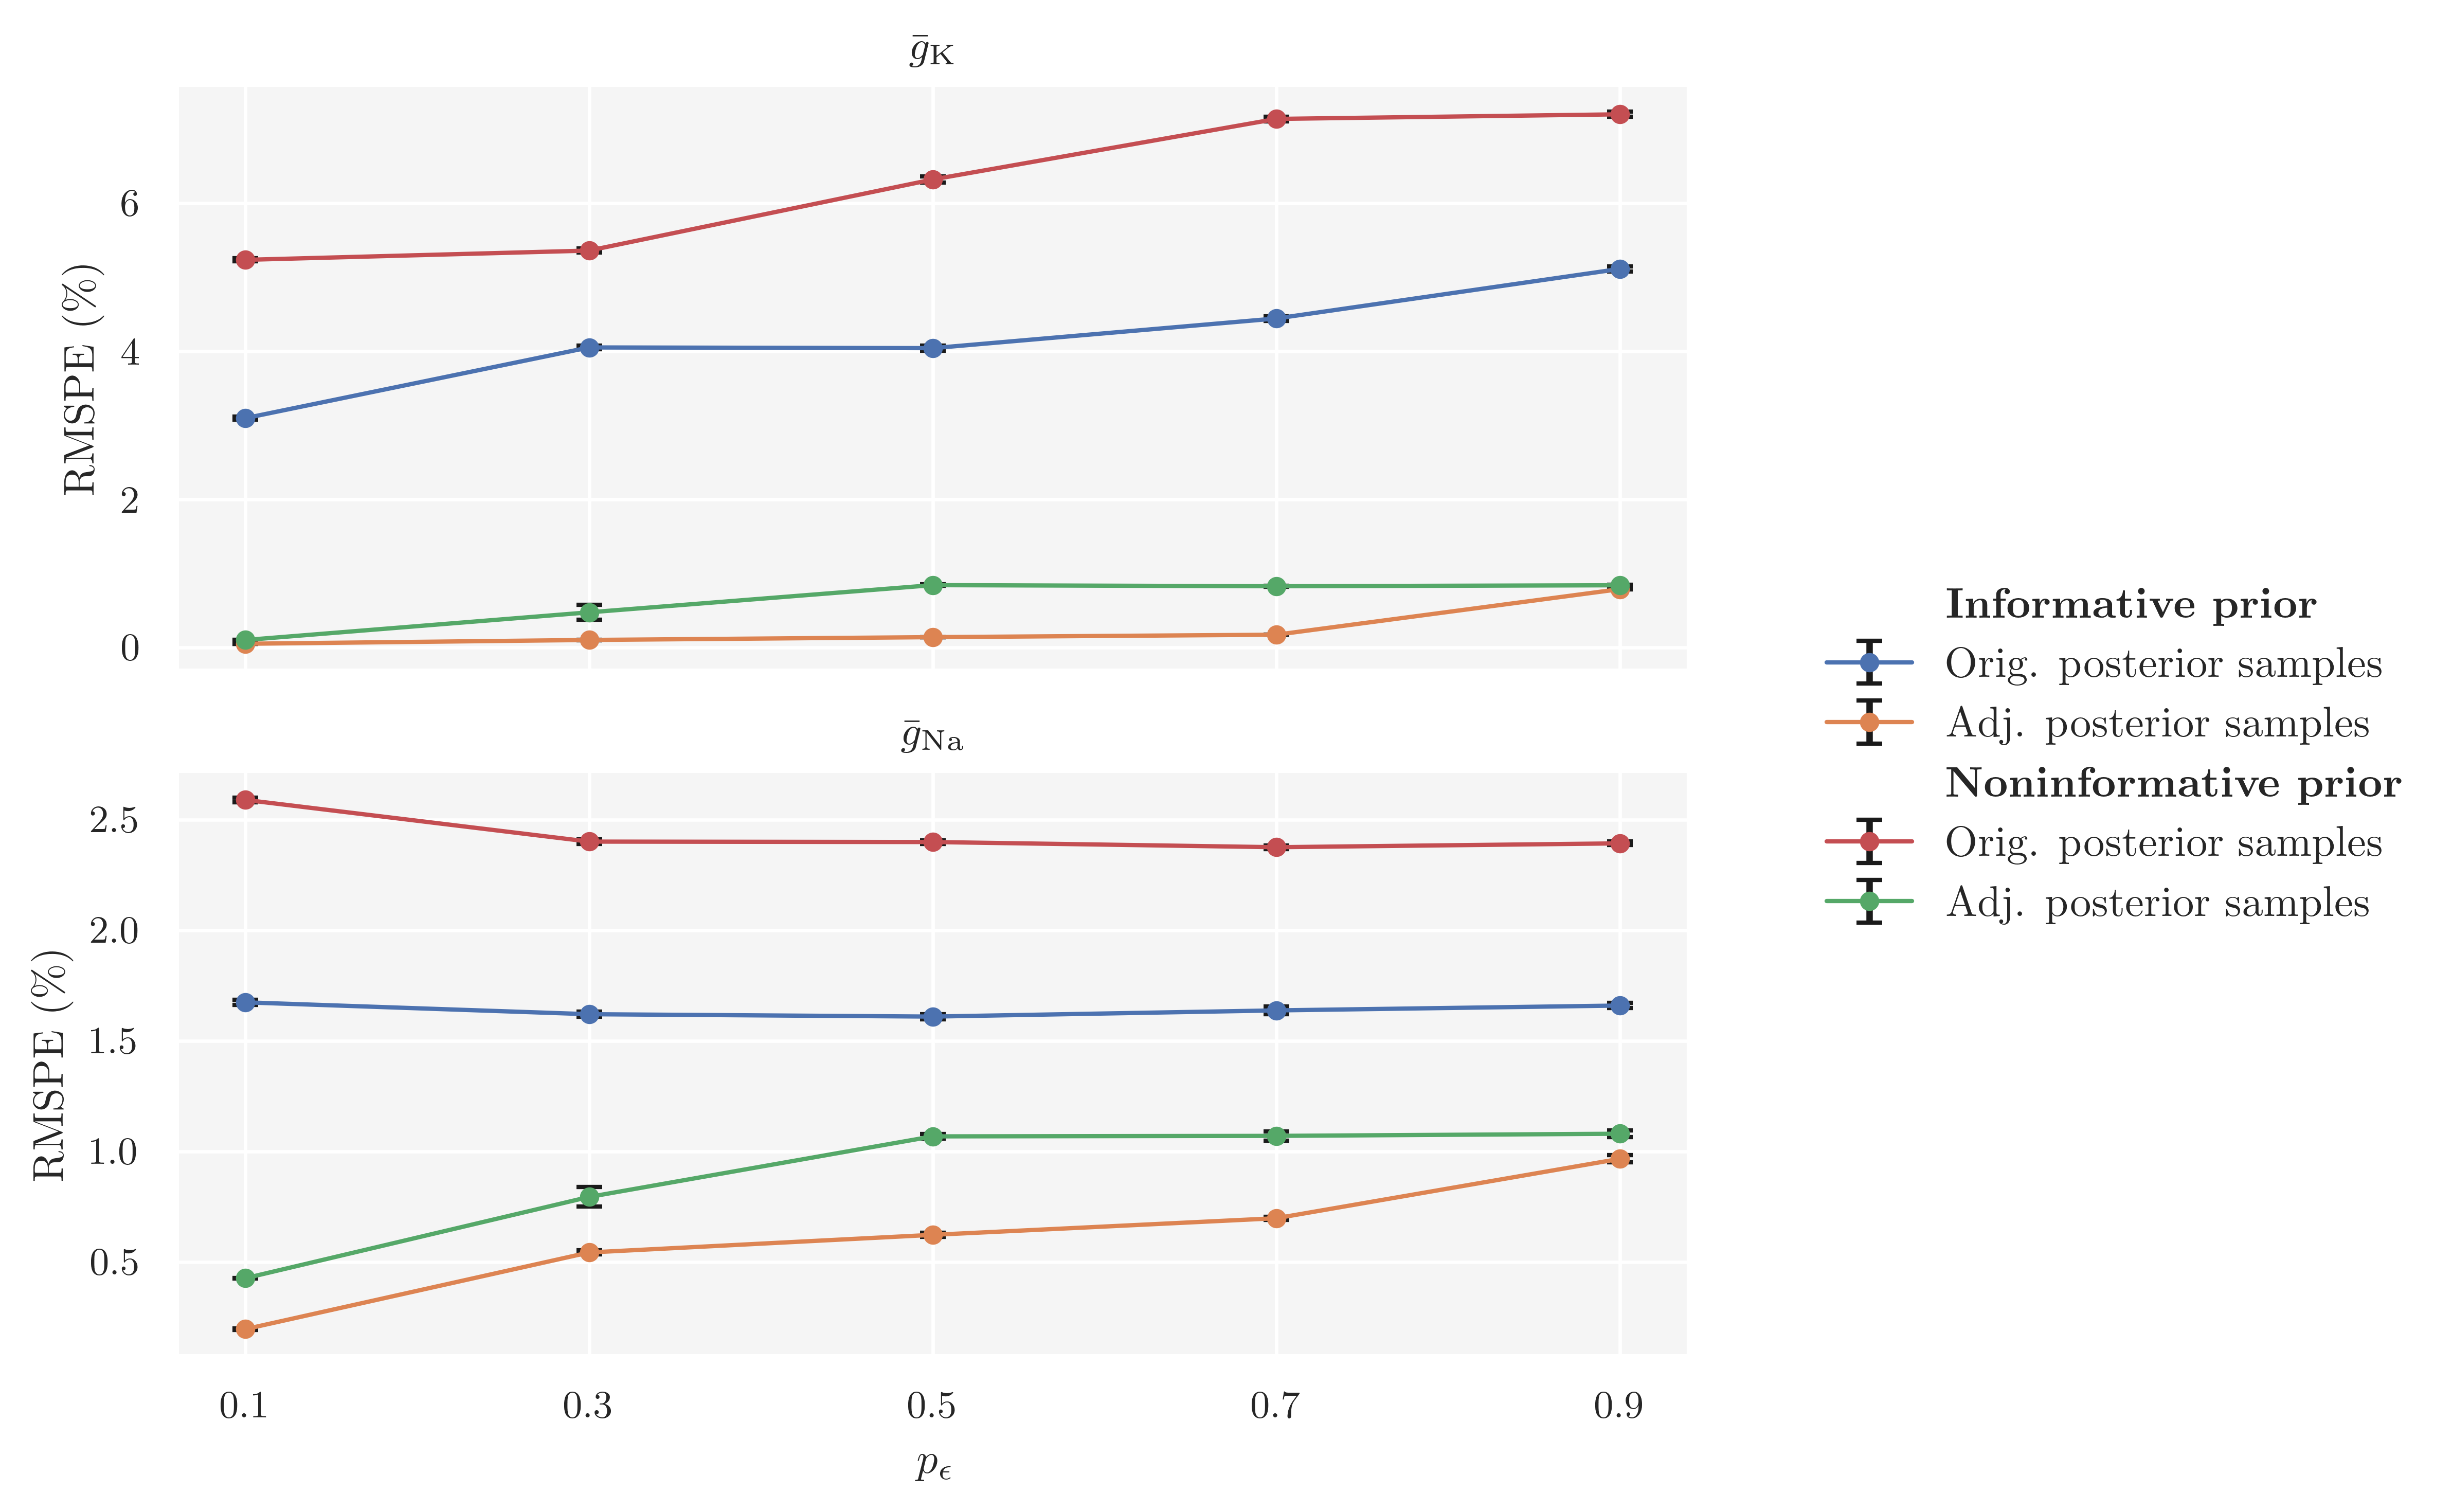

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(fs[0], 5), tight_layout=True, dpi=300, sharex=True)

# gbarK
ax = axes[0]
# informative prior
g1 = ax.errorbar(quantile_lst, 
            gbarK_org_rmspe_mean_norm, 
            yerr=gbarK_org_rmspe_sem_norm, 
            fmt='-o', 
            color='C0',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 
                
g2 = ax.errorbar(quantile_lst, 
            gbarK_reg_rmspe_mean_norm, 
            yerr=gbarK_reg_rmspe_sem_norm, 
            fmt='-o', 
            color='C1',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 


# noninformative prior
g3 = ax.errorbar(quantile_lst, 
            gbarK_org_rmspe_mean_unif, 
            yerr=gbarK_org_rmspe_sem_unif, 
            fmt='-o', 
            color='C3',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 
                
g4 = ax.errorbar(quantile_lst, 
            gbarK_reg_rmspe_mean_unif, 
            yerr=gbarK_reg_rmspe_sem_unif, 
            fmt='-o', 
            color='C2',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 

ax.set(
       #xticks=quantile_lst,
       #xlabel=r'$p_{\epsilon}$',
       ylabel="RMSPE (\%)",
       title=r'$\bar{g}_\mathrm{K}$'
       )


# gbarNa 
ax1 = axes[1]
# informative prior
ax1.errorbar(quantile_lst, 
            gbarNa_org_rmspe_mean_norm, 
            yerr=gbarNa_org_rmspe_sem_norm, 
            fmt='-o', 
            color='C0',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 
                
ax1.errorbar(quantile_lst, 
            gbarNa_reg_rmspe_mean_norm, 
            yerr=gbarNa_reg_rmspe_sem_norm, 
            fmt='-o', 
            color='C1',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 


# noninformative prior
ax1.errorbar(quantile_lst, 
            gbarNa_org_rmspe_mean_unif, 
            yerr=gbarNa_org_rmspe_sem_unif, 
            fmt='-o', 
            color='C3',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 
                
ax1.errorbar(quantile_lst, 
            gbarNa_reg_rmspe_mean_unif, 
            yerr=gbarNa_reg_rmspe_sem_unif, 
            fmt='-o', 
            color='C2',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 

ax1.set(xticks=quantile_lst,
       xlabel=r'$p_{\epsilon}$',
       ylabel="RMSPE (\%)",
       title=r'$\bar{g}_\mathrm{Na}$'
       )

# legend
title_proxy = matplotlib.patches.Rectangle((0, 0), 0, 0, visible=False)#, color='')
title1 = r"\textbf{Informative prior}"
title2 = r"\textbf{Noninformative prior}"
label1 = "Orig. posterior samples"
label2 = "Adj. posterior samples"

fig.legend([title_proxy, g1, g2, title_proxy, g3, g4],
          [title1, label1, label2, title2, label1, label2],
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          frameon=False,
          ncol=1
         )

fig.savefig(fig_path('RMSPE_vs_quantile.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

The less certain we are about a parameter a priori, the stricter should the threshold be 

### Computational time

Compromise between level of accuracy and computation efficiency

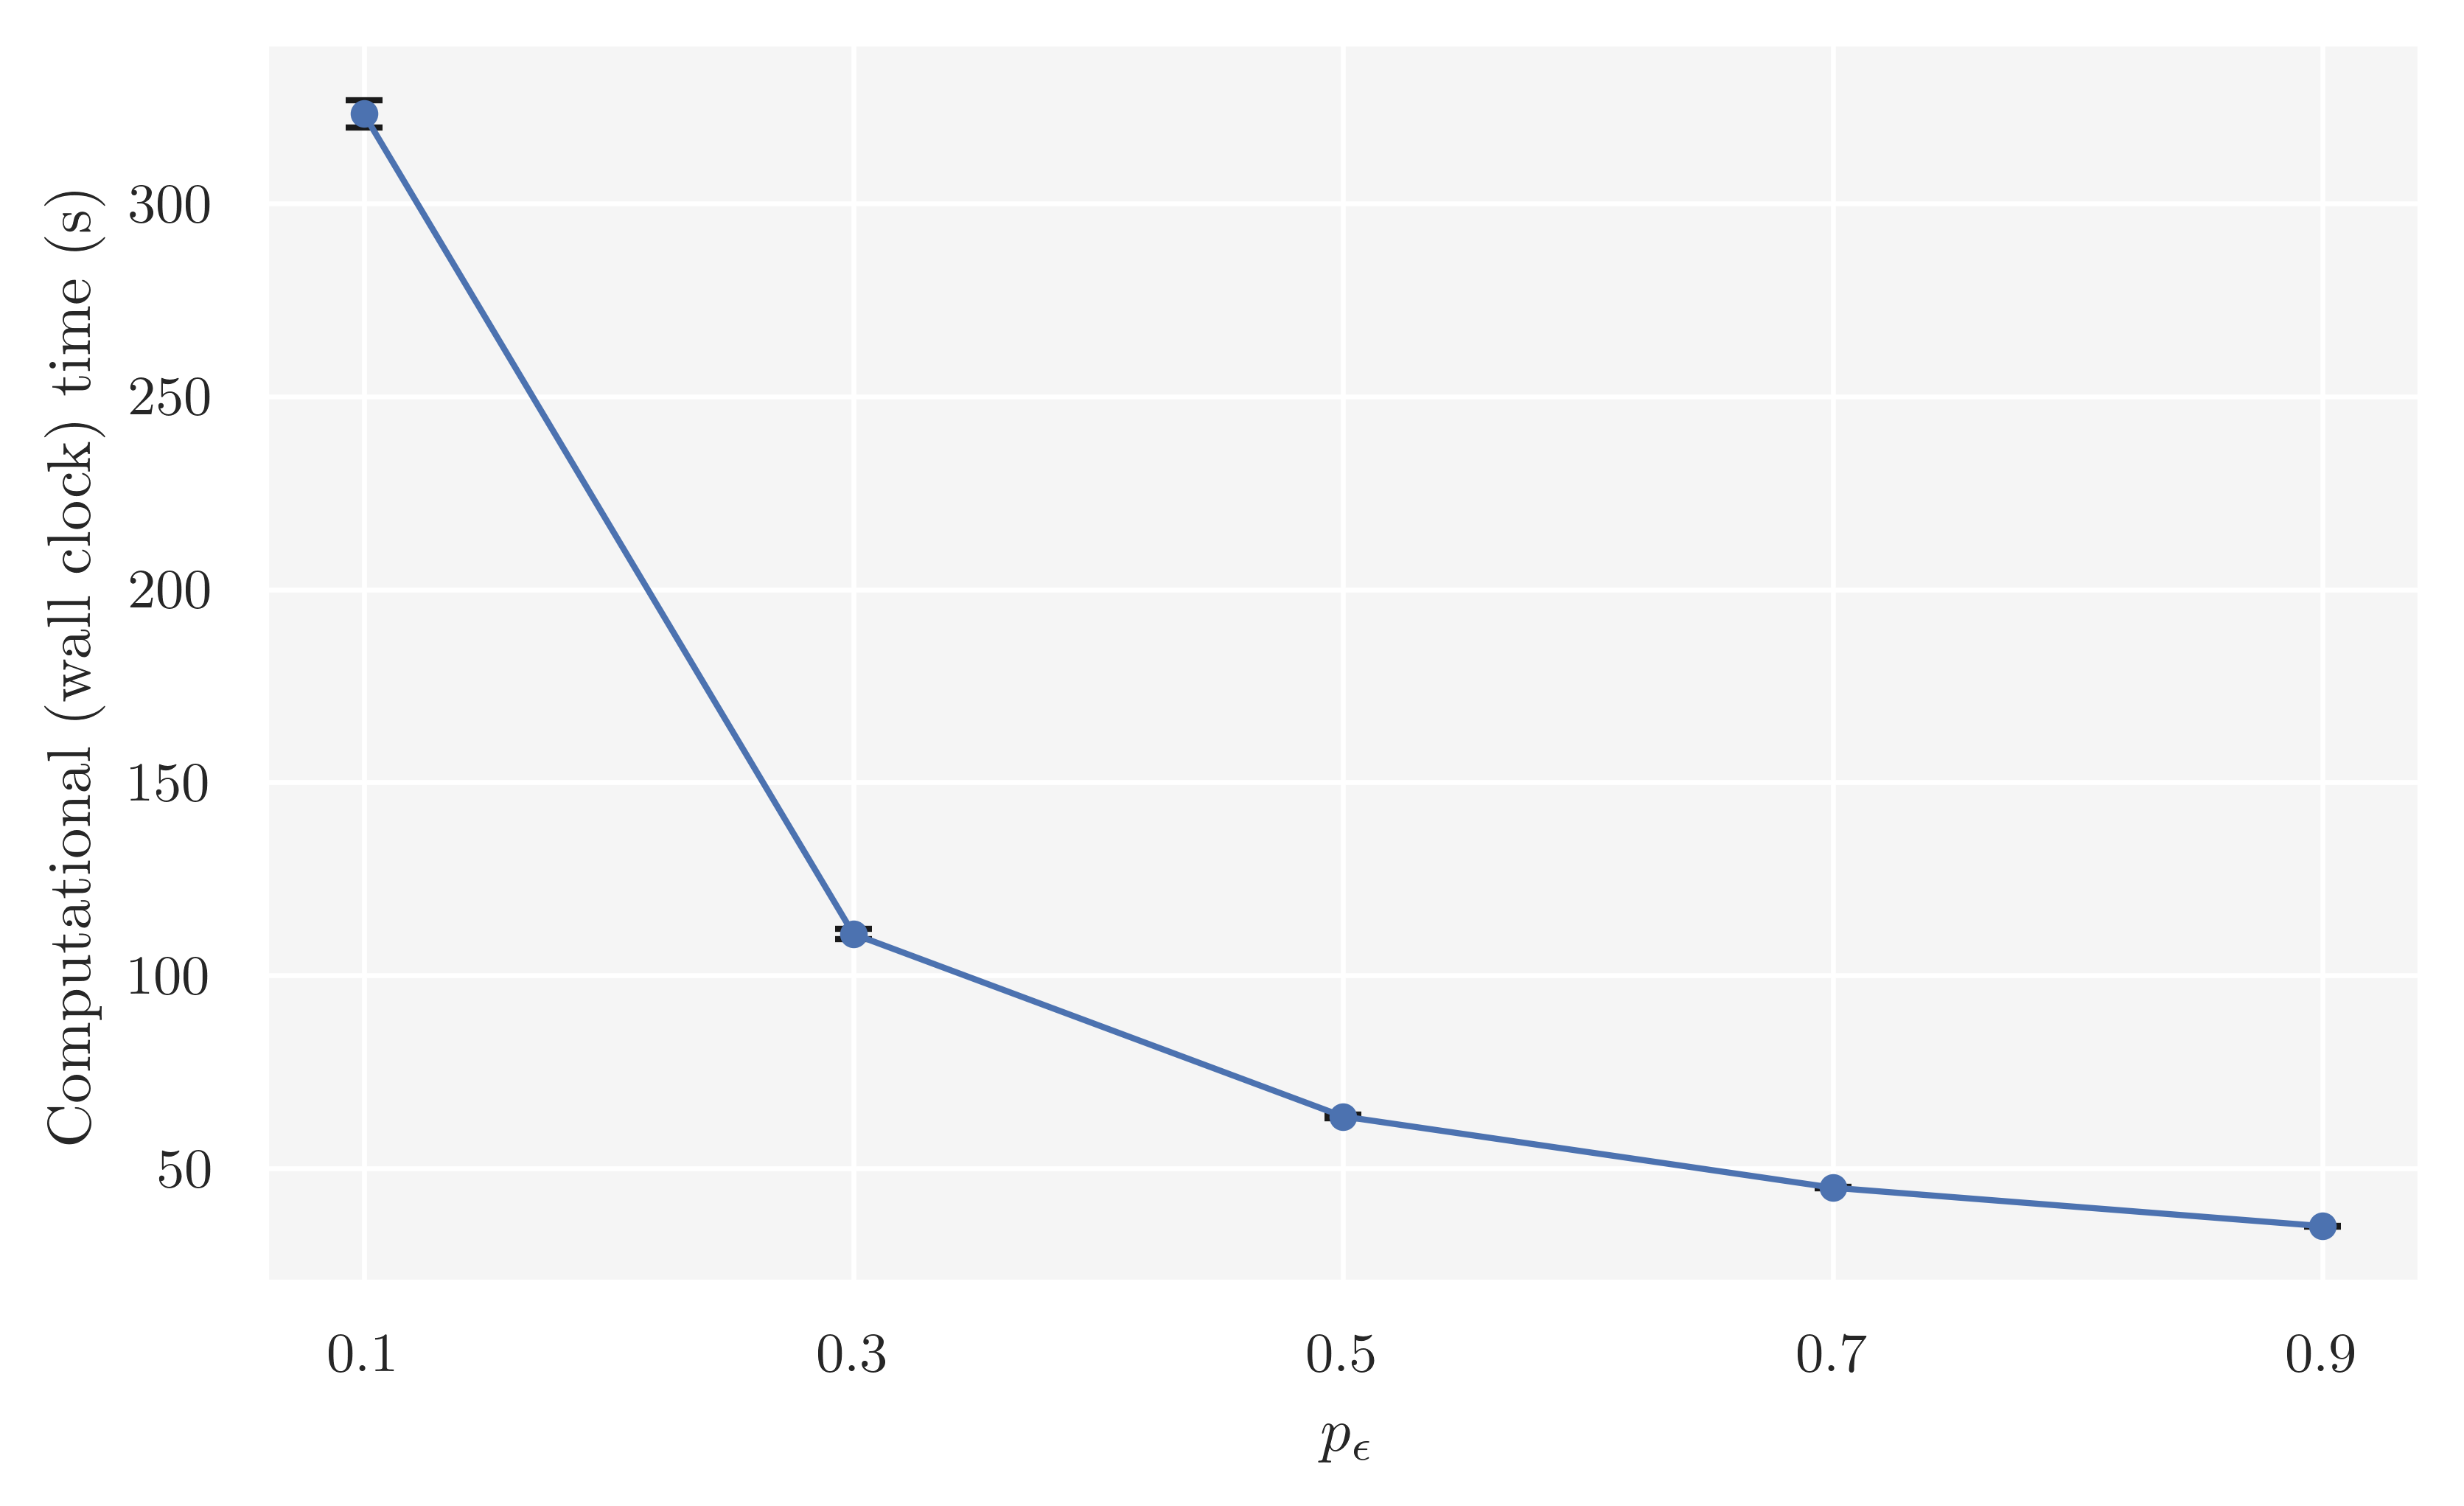

In [42]:
fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)

df_time = pd.read_csv('data/run_time_quantile.csv')
x_time = df_time['quantile'].unique()
mean_time = df_time.groupby('quantile').mean().to_numpy().ravel()
sem_time = df_time.groupby('quantile').sem().to_numpy().ravel() 

ax.errorbar(x_time, 
            mean_time, 
            yerr=sem_time, 
            fmt='-o', 
            color='C0',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           )

ax.set(xticks=x_time,
       xlabel=r'$p_{\epsilon}$',
       ylabel='Computational (wall clock) time (s)'
      )

fig.savefig(fig_path('comp_time_quantile.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

### RMSE vs number of posterior samples

p-quantile = 0.4 

pilot study: 2000 simulations 

3 summary statistics

In [43]:
gbarK0 = 36.    # ground truth
gbarNa0 = 120.  # ground truth

path = 'data/'

# iterators
nsamples_lst = [200, 500, 1000, 1500, 2000]
trials = 10
N = len(nsamples_lst)

# original posterior samples
gbarK_org_rmspe_mean_norm = np.zeros(N)
gbarK_org_rmspe_sem_norm = np.zeros(N)
gbarNa_org_rmspe_mean_norm = np.zeros(N)
gbarNa_org_rmspe_sem_norm = np.zeros(N)

gbarK_org_rmspe_mean_unif = np.zeros(N)
gbarK_org_rmspe_sem_unif = np.zeros(N)
gbarNa_org_rmspe_mean_unif = np.zeros(N)
gbarNa_org_rmspe_sem_unif = np.zeros(N)

# regression adjusted posterior samples
gbarK_reg_rmspe_mean_norm = np.zeros(N)
gbarK_reg_rmspe_sem_norm = np.zeros(N)
gbarNa_reg_rmspe_mean_norm = np.zeros(N)
gbarNa_reg_rmspe_sem_norm = np.zeros(N) 

gbarK_reg_rmspe_mean_unif = np.zeros(N)
gbarK_reg_rmspe_sem_unif = np.zeros(N)
gbarNa_reg_rmspe_mean_unif = np.zeros(N)
gbarNa_reg_rmspe_sem_unif = np.zeros(N)

for i, nsamples in enumerate(nsamples_lst):
    
    gbarK_true = np.ones(nsamples) * gbarK0
    gbarNa_true = np.ones(nsamples) * gbarNa0
    
    # original posterior samples
    trial_gbarK_rmspe_org_norm = np.zeros(trials)
    trial_gbarNa_rmspe_org_norm = np.zeros(trials)
    
    trial_gbarK_rmspe_org_unif = np.zeros(trials)
    trial_gbarNa_rmspe_org_unif = np.zeros(trials)
    
    # regression adjusted posterior samples
    trial_gbarK_rmspe_reg_norm = np.zeros(trials)
    trial_gbarNa_rmspe_reg_norm = np.zeros(trials)
    
    trial_gbarK_rmspe_reg_unif = np.zeros(trials)
    trial_gbarNa_rmspe_reg_unif = np.zeros(trials)
    
    for trial in range(trials):
        # Original posterior samples
        
        # normal prior
        filename = f'hh_rej_normal_org_nsamples_{nsamples}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        
        trial_gbarK_rmspe_org_norm[trial] = rmspe(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmspe_org_norm[trial] = rmspe(gbarNa_true, df["gbarNa"].to_numpy()) 
        
        # uniform prior
        filename = f'hh_rej_uniform_org_nsamples_{nsamples}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        
        trial_gbarK_rmspe_org_unif[trial] = rmspe(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmspe_org_unif[trial] = rmspe(gbarNa_true, df["gbarNa"].to_numpy()) 
        
        # Regression adjusted posterior samples
        
        # normal prior
        filename = f'hh_rej_normal_reg_nsamples_{nsamples}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        trial_gbarK_rmspe_reg_norm[trial] = rmspe(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmspe_reg_norm[trial] = rmspe(gbarNa_true, df["gbarNa"].to_numpy()) 
        
        # uniform prior
        filename = f'hh_rej_uniform_reg_nsamples_{nsamples}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        trial_gbarK_rmspe_reg_unif[trial] = rmspe(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmspe_reg_unif[trial] = rmspe(gbarNa_true, df["gbarNa"].to_numpy()) 
        
    # Mean and SEM of RMSPE samples
    
    # Original posterior
    
    # normal prior
    gbarK_org_rmspe_mean_norm[i] = np.mean(trial_gbarK_rmspe_org_norm)
    gbarK_org_rmspe_sem_norm[i] = sem(trial_gbarK_rmspe_org_norm) 
    gbarNa_org_rmspe_mean_norm[i] = np.mean(trial_gbarNa_rmspe_org_norm)
    gbarNa_org_rmspe_sem_norm[i] = sem(trial_gbarNa_rmspe_org_norm) 
    
    # uniform prior
    gbarK_org_rmspe_mean_unif[i] = np.mean(trial_gbarK_rmspe_org_unif)
    gbarK_org_rmspe_sem_unif[i] = sem(trial_gbarK_rmspe_org_unif) 
    gbarNa_org_rmspe_mean_unif[i] = np.mean(trial_gbarNa_rmspe_org_unif)
    gbarNa_org_rmspe_sem_unif[i] = sem(trial_gbarNa_rmspe_org_unif) 
    
    # Adjusted posterior
    # normal prior
    gbarK_reg_rmspe_mean_norm[i] = np.mean(trial_gbarK_rmspe_reg_norm)
    gbarK_reg_rmspe_sem_norm[i] = sem(trial_gbarK_rmspe_reg_norm) 
    gbarNa_reg_rmspe_mean_norm[i] = np.mean(trial_gbarNa_rmspe_reg_norm)
    gbarNa_reg_rmspe_sem_norm[i] = sem(trial_gbarNa_rmspe_reg_norm) 
    
    # uniform prior
    gbarK_reg_rmspe_mean_unif[i] = np.mean(trial_gbarK_rmspe_reg_unif)
    gbarK_reg_rmspe_sem_unif[i] = sem(trial_gbarK_rmspe_reg_unif) 
    gbarNa_reg_rmspe_mean_unif[i] = np.mean(trial_gbarNa_rmspe_reg_unif)
    gbarNa_reg_rmspe_sem_unif[i] = sem(trial_gbarNa_rmspe_reg_unif) 

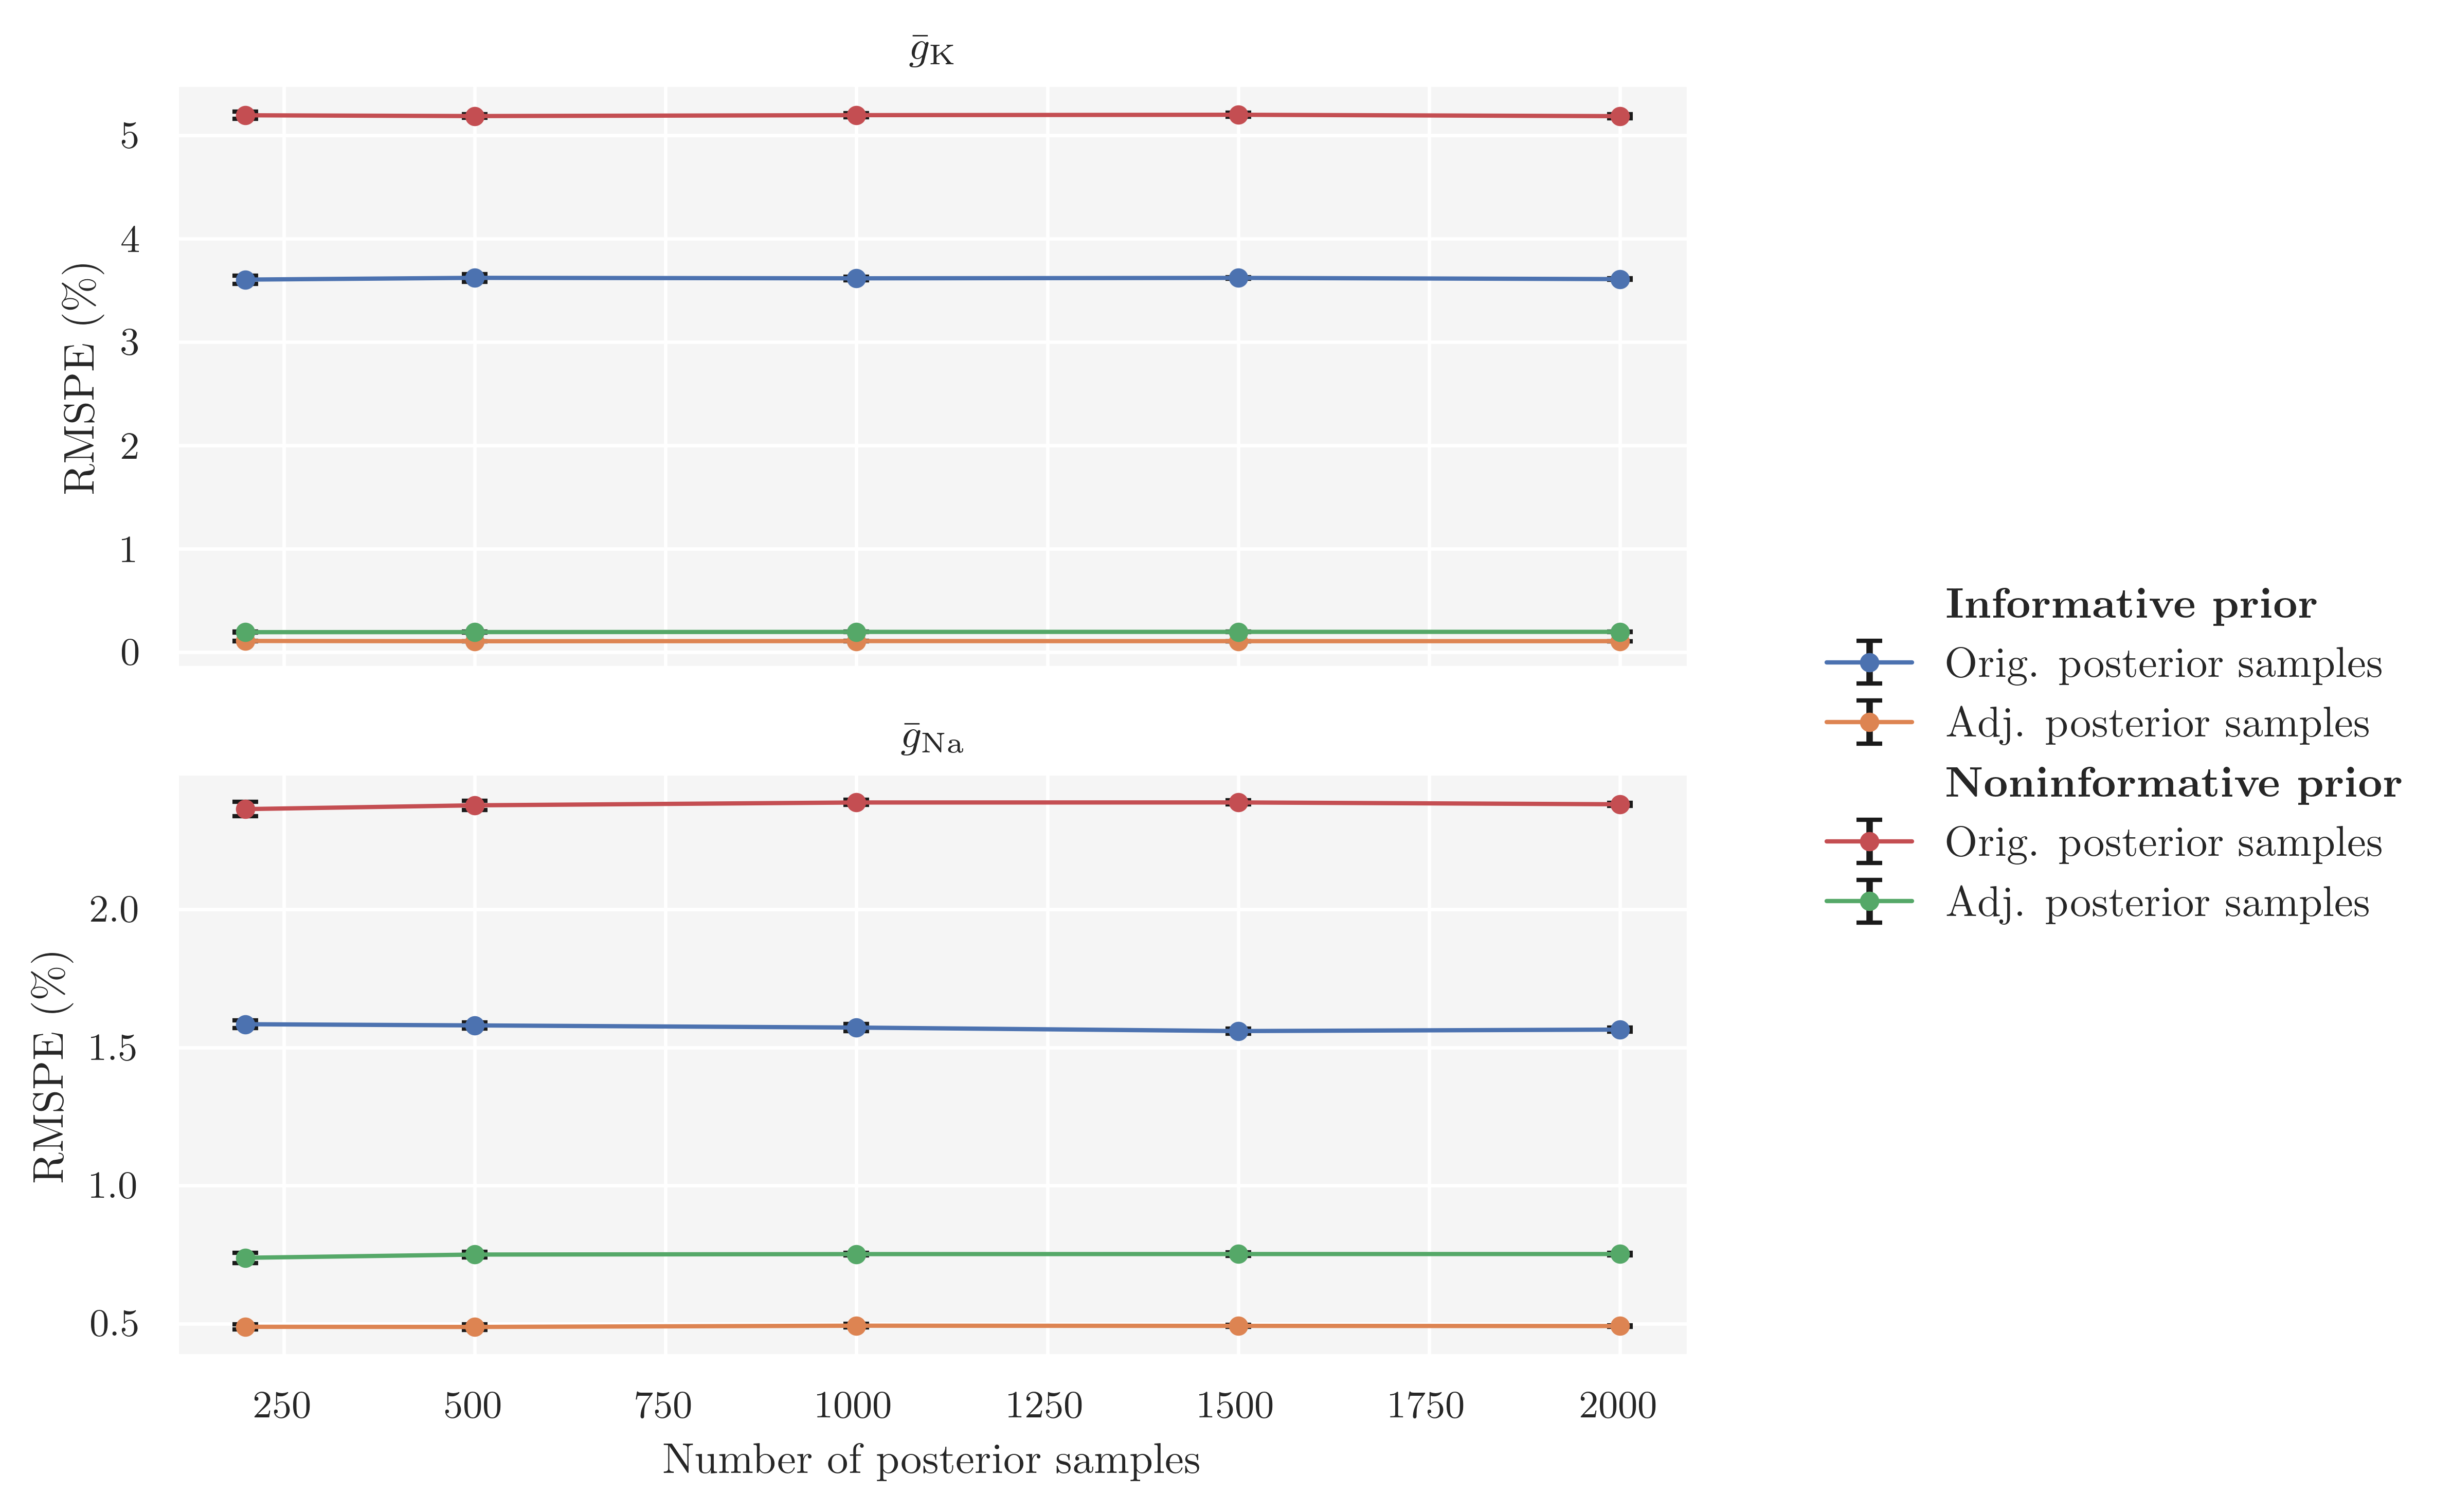

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(fs[0], 5), tight_layout=True, dpi=300, sharex=True)

# gbarK
ax = axes[0]
# informative prior
g1 = ax.errorbar(nsamples_lst, 
            gbarK_org_rmspe_mean_norm, 
            yerr=gbarK_org_rmspe_sem_norm, 
            fmt='-o', 
            color='C0',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 
                
g2 = ax.errorbar(nsamples_lst, 
            gbarK_reg_rmspe_mean_norm, 
            yerr=gbarK_reg_rmspe_sem_norm, 
            fmt='-o', 
            color='C1',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 


# noninformative prior
g3 = ax.errorbar(nsamples_lst, 
            gbarK_org_rmspe_mean_unif, 
            yerr=gbarK_org_rmspe_sem_unif, 
            fmt='-o', 
            color='C3',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 
                
g4 = ax.errorbar(nsamples_lst, 
            gbarK_reg_rmspe_mean_unif, 
            yerr=gbarK_reg_rmspe_sem_unif, 
            fmt='-o', 
            color='C2',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 

ax.set(
       #xticks=quantile_lst,
       #xlabel=r'$p_{\epsilon}$',
       ylabel="RMSPE (\%)",
       title=r'$\bar{g}_\mathrm{K}$'
       )


# gbarNa 
ax1 = axes[1]
# informative prior
ax1.errorbar(nsamples_lst, 
            gbarNa_org_rmspe_mean_norm, 
            yerr=gbarNa_org_rmspe_sem_norm, 
            fmt='-o', 
            color='C0',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 
                
ax1.errorbar(nsamples_lst, 
            gbarNa_reg_rmspe_mean_norm, 
            yerr=gbarNa_reg_rmspe_sem_norm, 
            fmt='-o', 
            color='C1',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 


# noninformative prior
ax1.errorbar(nsamples_lst, 
            gbarNa_org_rmspe_mean_unif, 
            yerr=gbarNa_org_rmspe_sem_unif, 
            fmt='-o', 
            color='C3',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 
                
ax1.errorbar(nsamples_lst, 
            gbarNa_reg_rmspe_mean_unif, 
            yerr=gbarNa_reg_rmspe_sem_unif, 
            fmt='-o', 
            color='C2',
            ecolor='k',
            markersize=3.5,
            lw=1.0, 
            elinewidth=1.5,
            capsize=3,
           ) 

ax1.set(
    #xticks=nsamples_lst,
       xlabel='Number of posterior samples',
       ylabel="RMSPE (\%)",
       title=r'$\bar{g}_\mathrm{Na}$'
       )

# legend
title_proxy = matplotlib.patches.Rectangle((0, 0), 0, 0, visible=False)#, color='')
title1 = r"\textbf{Informative prior}"
title2 = r"\textbf{Noninformative prior}"
label1 = "Orig. posterior samples"
label2 = "Adj. posterior samples"

fig.legend([title_proxy, g1, g2, title_proxy, g3, g4],
          [title1, label1, label2, title2, label1, label2],
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          frameon=False,
          ncol=1
         )

fig.savefig(fig_path('RMSPE_vs_nsamples.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

Result indicates that the number of posterior samples does not matter; the important hyperparameter is the threshold. As long as it is sufficiently small, we obtain, in particular after regression adjustment, posteriors with a high level of accuracy. 

There are, however, a reason for having a somewhat large size of posterior samples: KDE and visual representation.

### RMSPE vs number of sum stats

In [71]:
gbarK0 = 36.    # ground truth
gbarNa0 = 120.  # ground truth

n_samples = 1000
gbarK_true = np.ones(n_samples) * gbarK0
gbarNa_true = np.ones(n_samples) * gbarNa0

path = 'data/'

# iterators
s_stats_all = ["average_AP_overshoot",
               "spike_rate",
               "average_AP_width",
               "average_AHP_depth",
               "latency_to_first_spike",
               "accommodation_index"]

N = len(s_stats_all)

# eqaul weights
gbarK_rmspe_norm_ew = np.zeros(N)
gbarNa_rmspe_norm_ew = np.zeros(N)

gbarK_rmspe_unif_ew = np.zeros(N)
gbarNa_rmspe_unif_ew = np.zeros(N)

# importance weights
gbarK_rmspe_norm_iw = np.zeros(N)
gbarNa_rmspe_norm_iw = np.zeros(N)

gbarK_rmspe_unif_iw = np.zeros(N)
gbarNa_rmspe_unif_iw = np.zeros(N)

for i in range(N):
    
    # normal prior, equal weights
    filename = f'hh_rej_normal_nsumstats_{i+1}_eweights.jnl'
    journal = pylfi.Journal.load(path + filename)
    df = journal.df
    
    gbarK_rmspe_norm_ew[i] = rmspe(gbarK_true, df["gbarK"].to_numpy())
    gbarNa_rmspe_norm_ew[i] = rmspe(gbarNa_true, df["gbarNa"].to_numpy())  
    
    # uniform prior, equal weights 
    filename = f'hh_rej_uniform_nsumstats_{i+1}_eweights.jnl'
    journal = pylfi.Journal.load(path + filename)
    df = journal.df
    
    gbarK_rmspe_unif_ew[i] = rmspe(gbarK_true, df["gbarK"].to_numpy())
    gbarNa_rmspe_unif_ew[i] = rmspe(gbarNa_true, df["gbarNa"].to_numpy())
    
    # normal prior, importance weights
    filename = f'hh_rej_normal_nsumstats_{i+1}_iweights.jnl'
    journal = pylfi.Journal.load(path + filename)
    df = journal.df
    
    gbarK_rmspe_norm_iw[i] = rmspe(gbarK_true, df["gbarK"].to_numpy())
    gbarNa_rmspe_norm_iw[i] = rmspe(gbarNa_true, df["gbarNa"].to_numpy())
    
    # uniform prior, importance weights 
    filename = f'hh_rej_uniform_nsumstats_{i+1}_iweights.jnl'
    journal = pylfi.Journal.load(path + filename)
    df = journal.df
    
    gbarK_rmspe_unif_iw[i] = rmspe(gbarK_true, df["gbarK"].to_numpy())
    gbarNa_rmspe_unif_iw[i] = rmspe(gbarNa_true, df["gbarNa"].to_numpy())
    

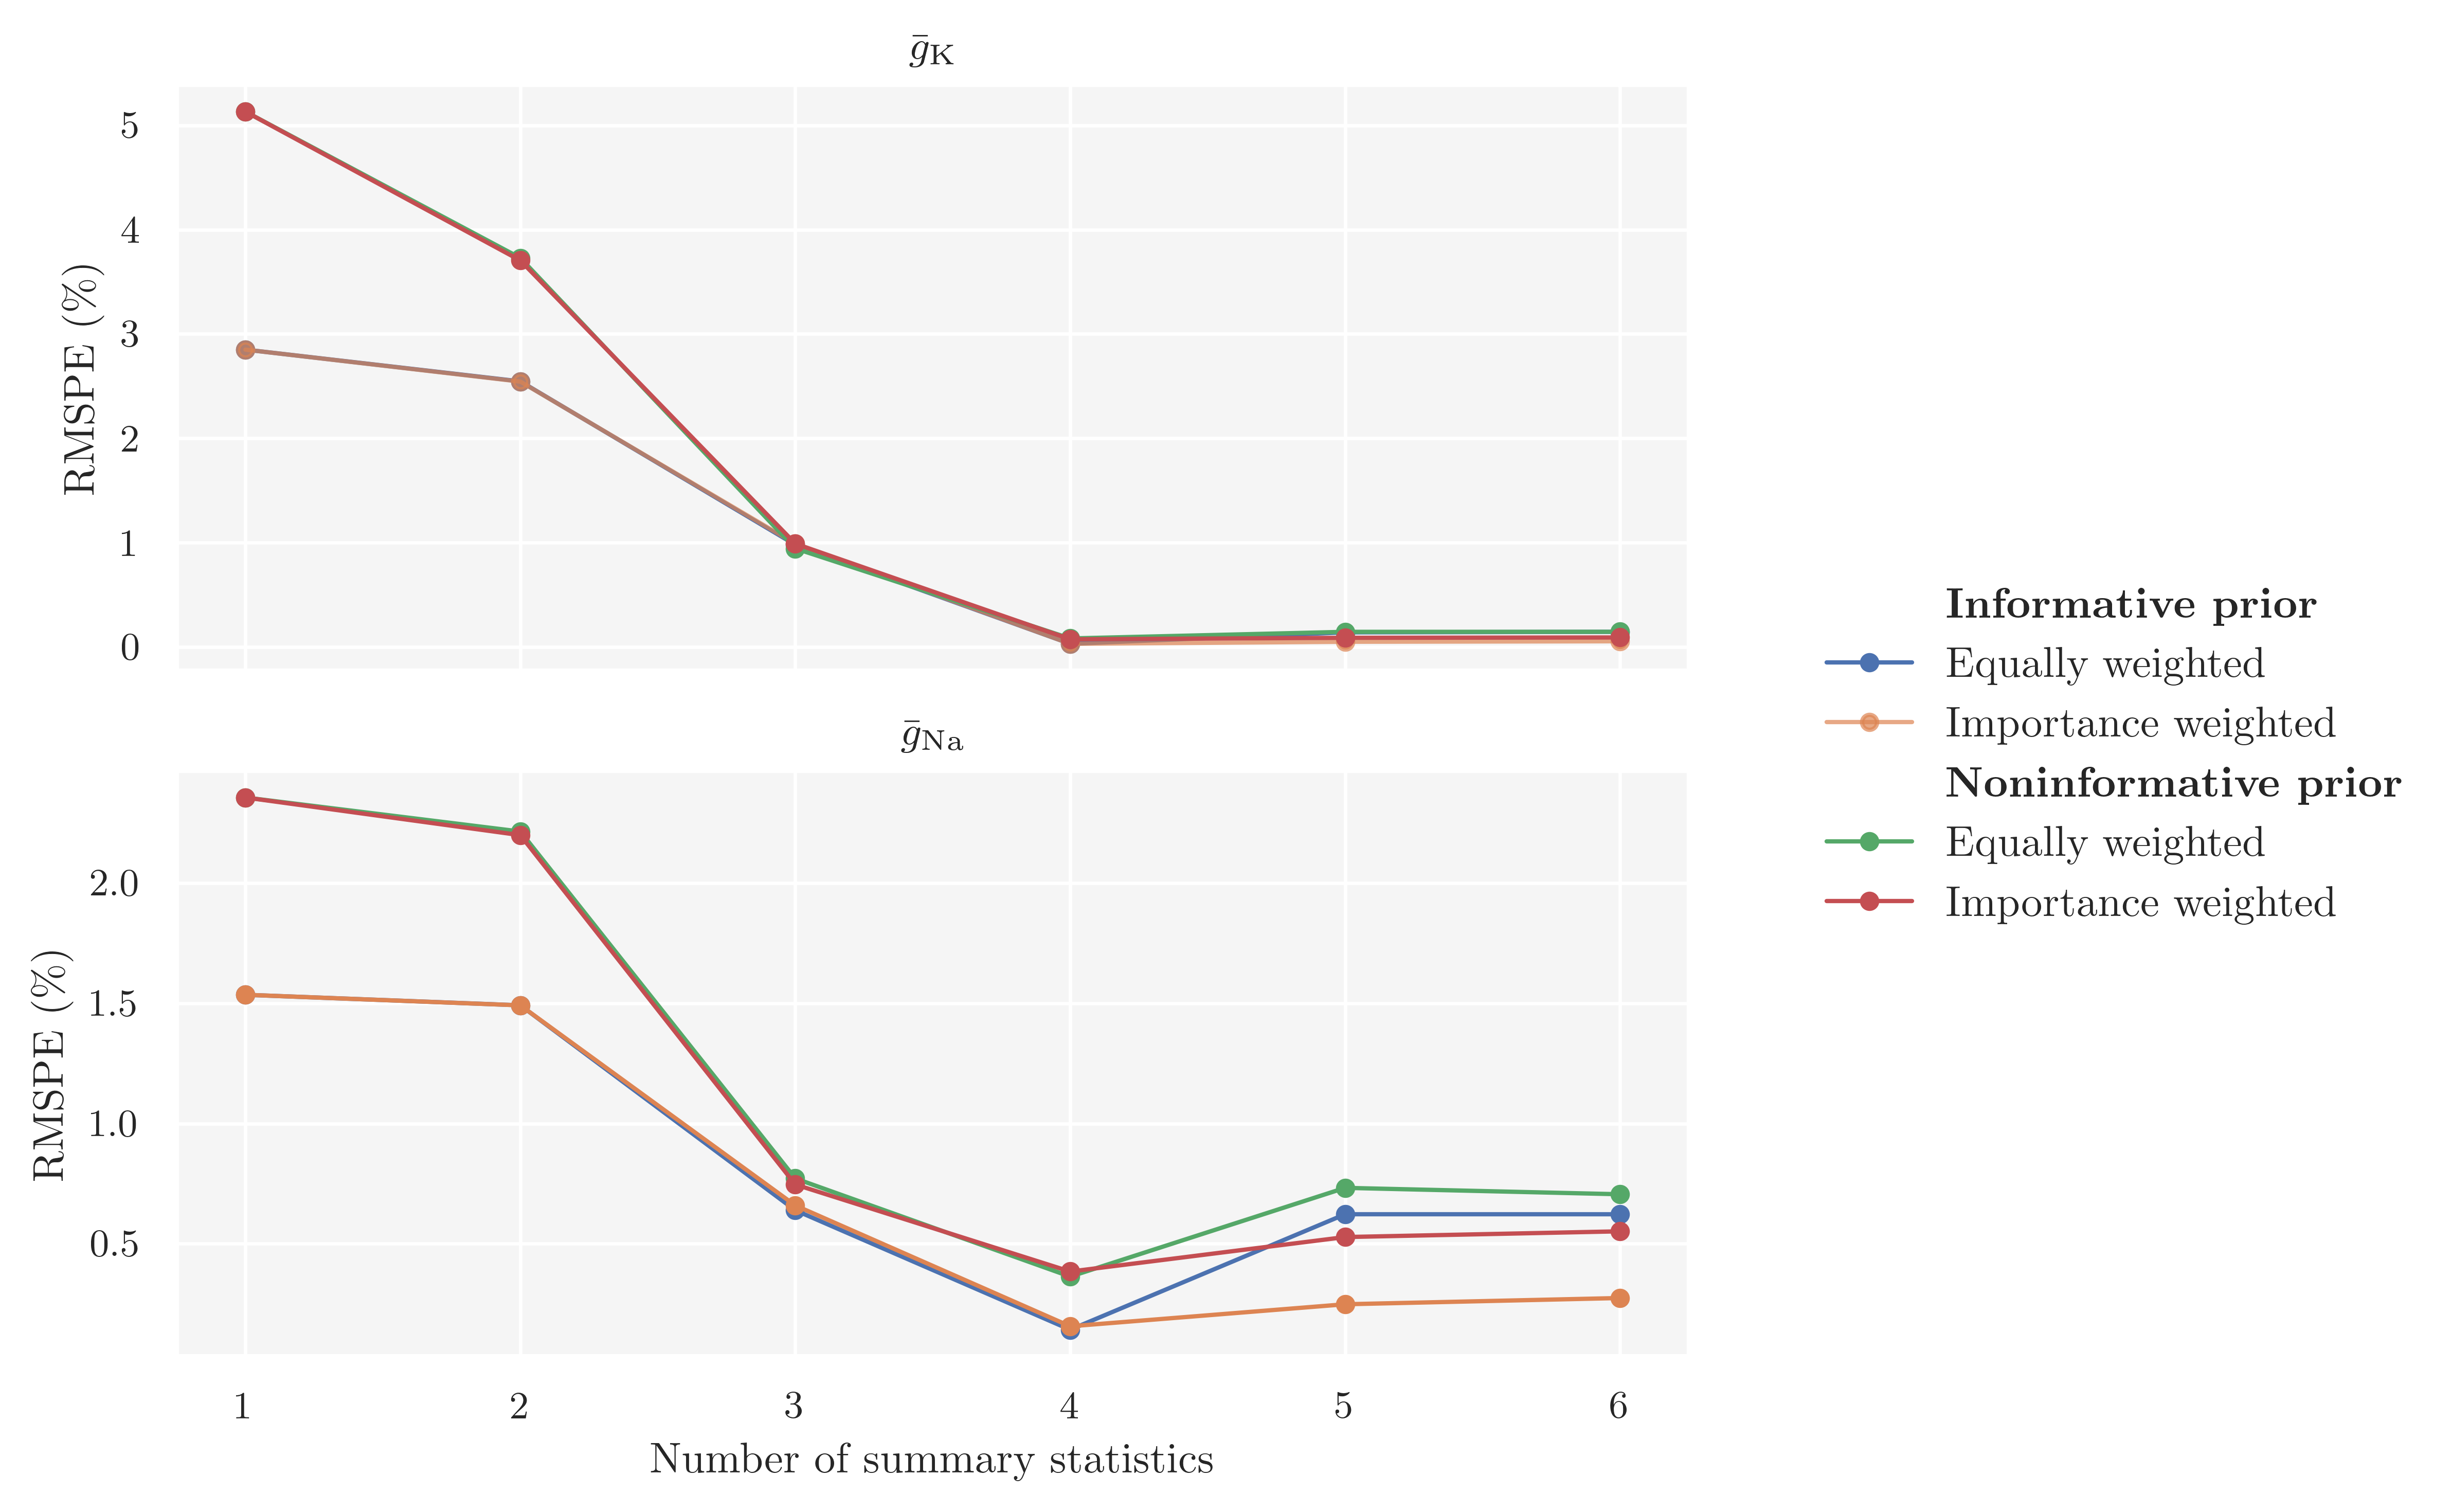

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(fs[0], 5), tight_layout=True, dpi=300, sharex=True)

n_sumstats = np.arange(1, N+1)

# gbarK
ax = axes[0]

# informative prior
g1, = ax.plot(n_sumstats, 
              gbarK_rmspe_norm_ew,
              '-o', 
              color='C0',
              markersize=3.5,
              lw=1.0
             )

g2, = ax.plot(n_sumstats, 
              gbarK_rmspe_norm_iw,
              '-o', 
              color='C1',
              markersize=3.5,
              alpha=0.7,
              lw=1.0
             ) 

# noninformative prior
g3, = ax.plot(n_sumstats, 
             gbarK_rmspe_unif_ew,
             '-o', 
             color='C2',
             markersize=3.5,
             lw=1.0
            )

g4, = ax.plot(n_sumstats, 
             gbarK_rmspe_unif_iw,
             '-o', 
             color='C3',
             markersize=3.5,
             lw=1.0
            ) 

ax.set(ylabel="RMSPE (\%)",
       title=r'$\bar{g}_\mathrm{K}$'
       )


# gbarNa
ax1 = axes[1]

# informative prior
ax1.plot(n_sumstats,
         gbarNa_rmspe_norm_ew,
         '-o', 
         color='C0',
         markersize=3.5,
         lw=1.0
        )

ax1.plot(n_sumstats, 
         gbarNa_rmspe_norm_iw,
         '-o', 
         color='C1',
         markersize=3.5,
         lw=1.0
        ) 

# noninformative prior
ax1.plot(n_sumstats, 
         gbarNa_rmspe_unif_ew,
         '-o', 
         color='C2',
         markersize=3.5,
         lw=1.0
        )

ax1.plot(n_sumstats,
         gbarNa_rmspe_unif_iw,
         '-o', 
         color='C3',
         markersize=3.5,
         lw=1.0
        ) 

ax1.set(
    #xticks=nsamples_lst,
       xlabel='Number of summary statistics',
       ylabel="RMSPE (\%)",
       title=r'$\bar{g}_\mathrm{Na}$'
       )

# legend
title_proxy = matplotlib.patches.Rectangle((0, 0), 0, 0, visible=False)#, color='')
title1 = r"\textbf{Informative prior}"
title2 = r"\textbf{Noninformative prior}"
label1 = "Equally weighted"
label2 = "Importance weighted"

fig.legend([title_proxy, g1, g2, title_proxy, g3, g4],
          [title1, label1, label2, title2, label1, label2],
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          frameon=False,
          ncol=1
         )

''' 
fig.savefig(fig_path('RMSPE_vs_n_sumstats.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )
'''
plt.show()

In [6]:
gbarK0 = 36.    # ground truth
gbarNa0 = 120.  # ground truth
gbarK_true = np.ones(1000) * gbarK0
gbarNa_true = np.ones(1000) * gbarNa0

path = 'data/'

# iterators
quantile_lst = [0.1, 0.3, 0.5, 0.7, 0.9]
trials = 10
N = len(quantile_lst)

# original posterior samples
gbarK_org_rmse_mean = np.zeros(N)
gbarK_org_rmse_sem = np.zeros(N)
gbarNa_org_rmse_mean = np.zeros(N)
gbarNa_org_rmse_sem = np.zeros(N)

# regression adjusted posterior samples
gbarK_reg_rmse_mean = np.zeros(N)
gbarK_reg_rmse_sem = np.zeros(N)
gbarNa_reg_rmse_mean = np.zeros(N)
gbarNa_reg_rmse_sem = np.zeros(N)

for i, quantile in enumerate(quantile_lst):
    quantile_str = str(quantile).replace('.', '_')
    
    # original posterior samples
    trial_gbarK_rmse_org = np.zeros(trials)
    trial_gbarNa_rmse_org = np.zeros(trials)
    
    # regression adjusted posterior samples
    trial_gbarK_rmse_reg = np.zeros(trials)
    trial_gbarNa_rmse_reg = np.zeros(trials)
    
    for trial in range(trials):
        # original posterior samples
        filename = f'hh_rej_normal_org_quantile_{quantile_str}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        #trial_gbarK_rmse_org[trial] = rmse(gbarK_true, df["gbarK"].to_numpy())
        #trial_gbarNa_rmse_org[trial] = rmse(gbarNa_true, df["gbarNa"].to_numpy()) 
        trial_gbarK_rmse_org[trial] = rmspe(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmse_org[trial] = rmspe(gbarNa_true, df["gbarNa"].to_numpy()) 
        
        # regression adjusted posterior samples
        filename = f'hh_rej_normal_reg_quantile_{quantile_str}_run_{trial}.jnl'
        journal = pylfi.Journal.load(path + filename)
        df = journal.df
        trial_gbarK_rmse_reg[trial] = rmse(gbarK_true, df["gbarK"].to_numpy())
        trial_gbarNa_rmse_reg[trial] = rmse(gbarNa_true, df["gbarNa"].to_numpy()) 
        
    # Mean and SEM of RMSE samples
    # Original posterior
    gbarK_org_rmse_mean[i] = np.mean(trial_gbarK_rmse_org)
    gbarK_org_rmse_sem[i] = sem(trial_gbarK_rmse_org) 
    gbarNa_org_rmse_mean[i] = np.mean(trial_gbarNa_rmse_org)
    gbarNa_org_rmse_sem[i] = sem(trial_gbarNa_rmse_org) 
    
    # Adjusted posterior
    gbarK_reg_rmse_mean[i] = np.mean(trial_gbarK_rmse_reg)
    gbarK_reg_rmse_sem[i] = sem(trial_gbarK_rmse_reg) 
    gbarNa_reg_rmse_mean[i] = np.mean(trial_gbarNa_rmse_reg)
    gbarNa_reg_rmse_sem[i] = sem(trial_gbarNa_rmse_reg)

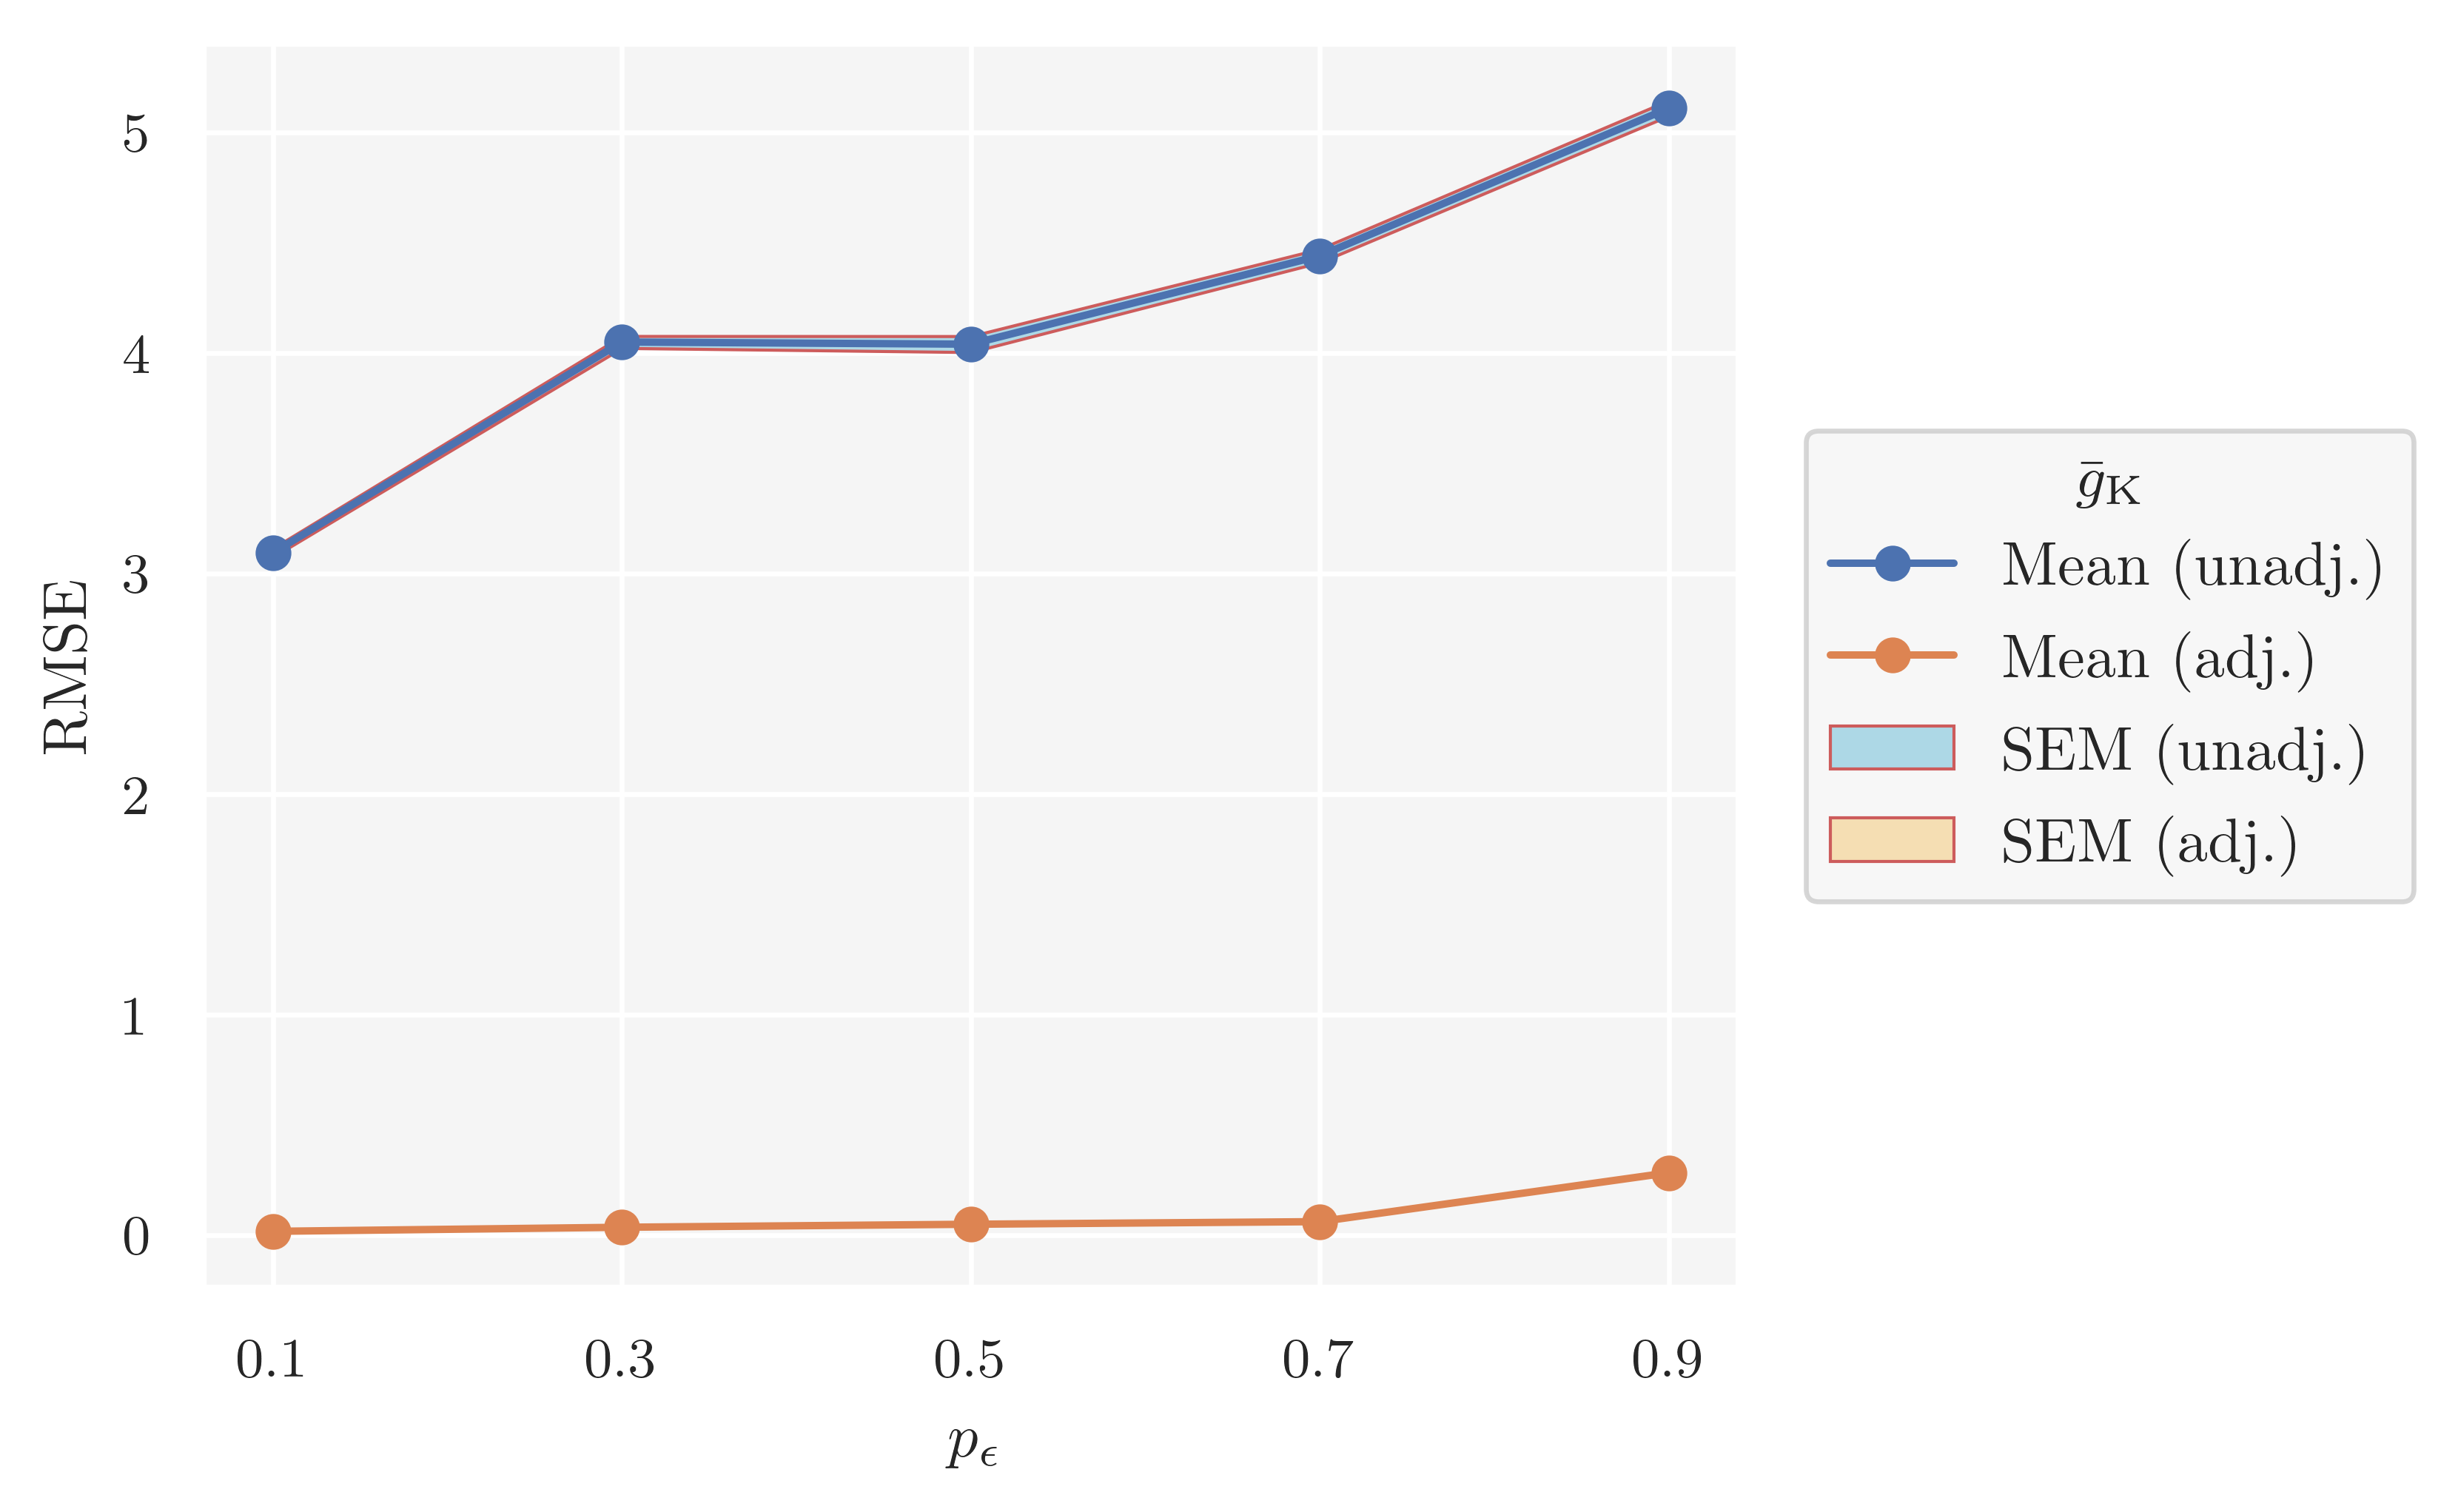

In [8]:
# gbarK

fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
# original posterior samples
ax.plot(quantile_lst, 
        gbarK_org_rmse_mean, 
        '-o',
        label='Mean (unadj.)', 
        color='C0'
        )
ax.fill_between(quantile_lst, 
                gbarK_org_rmse_mean - gbarK_org_rmse_sem, 
                gbarK_org_rmse_mean + gbarK_org_rmse_sem,
                alpha=1.0,
                edgecolor='indianred',
                facecolor='lightblue',
                lw=0.5,
                label='SEM (unadj.)'
                )
# regression adjusted posterior samples
ax.plot(quantile_lst, 
        gbarK_reg_rmse_mean, 
        '-o', 
        label='Mean (adj.)', 
        color='C1'
        )
ax.fill_between(quantile_lst, 
                gbarK_reg_rmse_mean - gbarK_reg_rmse_sem, 
                gbarK_reg_rmse_mean + gbarK_reg_rmse_sem,
                alpha=1.0,
                edgecolor='indianred',
                facecolor='wheat',
                lw=0.5,
                label='SEM (adj.)'
                )

ax.set(xticks=quantile_lst,
       xlabel=r'$p_{\epsilon}$',
       ylabel="RMSE",
       )
ax.legend()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,
          labels,
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          ncol=1,
          title=r'$\bar{g}_\mathrm{K}$'
         )
plt.show()